In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from tqdm import tqdm
import re

from collections import Counter
from collections import defaultdict

#### 1. Data Collection

In [60]:
df = pd.read_csv('output_partial_text_type.csv')


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8633 entries, 0 to 8632
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   source       8633 non-null   object 
 1   text         8633 non-null   object 
 2   date         6600 non-null   object 
 3   position     8633 non-null   object 
 4   vacancy      8633 non-null   object 
 5   company      7942 non-null   object 
 6   city         5772 non-null   object 
 7   country      8479 non-null   object 
 8   region       5740 non-null   object 
 9   level        8633 non-null   object 
 10  experience   7177 non-null   object 
 11  employment   8232 non-null   object 
 12  schedule     8427 non-null   object 
 13  skills       8263 non-null   object 
 14  salary from  8633 non-null   float64
 15  salary to    8633 non-null   float64
 16  text_type    8633 non-null   object 
dtypes: float64(2), object(15)
memory usage: 1.1+ MB


In [62]:

df = df.drop_duplicates(subset=['text'])

In [63]:
df.shape[0]

8633

In [64]:
df_copy = df.copy()

#### 2. Data Cleaning + Data Preparation

In [69]:
# уберем резюме
df_copy = df_copy.loc[df_copy['text_type'] == 'вакансия']

In [71]:
df_copy.shape[0]

8429

In [72]:
# дубликаты
columns_to_check = [col for col in df_copy.columns if col != 'date']
duplicates = df_copy[df_copy.duplicated(subset=columns_to_check, keep='first')]
print(f"Найдено дубликатов: {len(duplicates)}")

Найдено дубликатов: 0


In [32]:
# Удалим строки с пустыми признаками 

#df_copy = df_copy.dropna(subset=['experience', 'country','skills'],  how='any')

In [73]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8429 entries, 0 to 8632
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   source       8429 non-null   object 
 1   text         8429 non-null   object 
 2   date         6397 non-null   object 
 3   position     8429 non-null   object 
 4   vacancy      8429 non-null   object 
 5   company      7936 non-null   object 
 6   city         5724 non-null   object 
 7   country      8276 non-null   object 
 8   region       5692 non-null   object 
 9   level        8429 non-null   object 
 10  experience   6991 non-null   object 
 11  employment   8032 non-null   object 
 12  schedule     8226 non-null   object 
 13  skills       8061 non-null   object 
 14  salary from  8429 non-null   float64
 15  salary to    8429 non-null   float64
 16  text_type    8429 non-null   object 
dtypes: float64(2), object(15)
memory usage: 1.2+ MB


In [74]:
df_copy= df_copy.drop('text_type', axis =1)

In [76]:
df = df_copy

In [79]:
mask = df_copy['text'].str.contains(r'#резюме|#resume', case=False, na=False)
display(df_copy[mask].shape[0])  # Покажет строки для удаления

1

In [80]:
df_copy = df_copy[~mask]  # Удаляем

In [ ]:
#temp1 = pd.read_csv('output_partial_text_type.csv')

In [ ]:
#temp1['text_type'].value_counts(dropna=False)

text_type
вакансия    8429
резюме       204
Name: count, dtype: int64

In [ ]:
'''
with pd.option_context(
    'display.max_rows', None,          # Показать все строки
    'display.max_columns', None,       # Показать все столбцы
    'display.max_colwidth', 100       # Полный текст в ячейках
):

    display(temp1[temp1['text_type'] == 'резюме']['text'])
'''

In [106]:
# посмотрим на маленькие з/п
mask = ((df_copy['salary from'] <= 10000) | (df_copy['salary to'] <= 10000))
df_copy[mask].shape

(66, 16)

In [ ]:
with pd.option_context(
    'display.max_rows', None,          # Показать все строки
    'display.max_columns', None,       # Показать все столбцы
    'display.max_colwidth', None       # Полный текст в ячейках
):
    

    display(df_copy[mask][['position','region','experience','salary from','salary to','text', 'employment']])

In [85]:
# 1. точно тысячи < 800

cols_to_multiply = ['salary from', 'salary to']
mask = (df_copy['salary from'] < 800) & (df_copy['salary to'] < 800)
df_copy.loc[mask, cols_to_multiply] *= 1000


In [ ]:
# 2. Полная занятость от 800 до 3500 в час
cols_to_multiply = ['salary from', 'salary to']
mask = (df_copy['salary from'] <= 4000) & (df_copy['salary to'] <= 4000) & (df_copy['employment'] =='Полная занятость')
df_copy.loc[mask, cols_to_multiply] *= 160


In [102]:
# 2. Более 6 лет опыта  от  3500  до 5000 в час / Полная занятость
cols_to_multiply = ['salary from', 'salary to']
mask = (df_copy['salary from'] <= 5000) & (df_copy['salary to'] <= 5000) & (df_copy['employment'] =='Полная занятость') & (df_copy['experience'] =='Более 6 лет')
df_copy.loc[mask, cols_to_multiply] *= 160

In [107]:
# все остальное сносим 
mask = ((df_copy['salary from'] <= 10000) | (df_copy['salary to'] <= 10000))
df_copy = df_copy.loc[~mask]

In [152]:
df_copy.shape[0]

8362

In [153]:
df = df_copy.copy()

##### 2.1 Skills

In [154]:
df = df.dropna(subset=['skills'])

In [155]:
df.shape[0]

7998

In [156]:
# Преобразование skills в список 

from ast import literal_eval

def convert_to_list(value):
    if isinstance(value, list):  # Если уже список - возвращаем как есть
        return value
    try:
        # Пробуем распарсить строку как список (если формат подходящий)
        return literal_eval(str(value))
    except (ValueError, SyntaxError):
        # Если не получается - разбиваем по запятым
        return [s.strip() for s in str(value).split(',') if s.strip()]

# Применяем функцию ко всем значениям столбца skills
df['skills_list'] = df['skills'].apply(convert_to_list)

In [157]:
# Функция для очистки пустых списков
def clean_skills(skill_data):
    if isinstance(skill_data, list):
        if len(skill_data) == 0:  # Пустой список []
            return np.nan
        if len(skill_data) == 1 and isinstance(skill_data[0], list) and len(skill_data[0]) == 0:  # Список с пустым списком [[]]
            return np.nan
    return skill_data

# Применяем очистку
df['skills_list'] = df['skills_list'].apply(clean_skills)

In [158]:

# 1. Преобразуем все skills в плоский список отдельных навыков
def flatten_skills(skills_series):
    all_skills = []
    for skill_list in skills_series:
        if isinstance(skill_list, list):
            all_skills.extend(skill_list)
    return all_skills


# 2. Собираем все навыки в один список
all_skills = flatten_skills(df['skills_list'])

# 3. Подсчет уникальных навыков
unique_skills_count = len(set(all_skills))  # Количество уникальных навыков
skills_frequency = Counter(all_skills)      # Частота каждого навыка

print(f"Общее количество уникальных навыков: {unique_skills_count}")

# 4. Топ-20 самых популярных навыков
top_skills = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['Количество'])
top_skills = top_skills.sort_values('Количество', ascending=False).head(50)

print("\nТоп-20 самых популярных навыков:")
print(top_skills)

Общее количество уникальных навыков: 17561

Топ-20 самых популярных навыков:
              Количество
SQL                 1417
Python              1378
Docker              1292
PostgreSQL          1193
Linux               1120
Git                 1032
Kubernetes           928
CI/CD                641
Java                 638
Kafka                621
Ansible              597
Grafana              566
Prometheus           483
Redis                463
REST                 443
Jira                 406
MySQL                405
RabbitMQ             380
TypeScript           362
REST API             354
Jenkins              348
Bash                 346
JavaScript           343
PHP                  323
Confluence           313
Postman              302
Terraform            299
React                291
C#                   249
Zabbix               244
BPMN                 230
Go                   227
ООП                  222
HTML                 219
SOAP                 218
C++                  21

In [159]:
def normalize_skills(raw):
    if raw is None or (isinstance(raw, float) and np.isnan(raw)):
        return None

    if isinstance(raw, np.ndarray):
        raw = raw.tolist()

    # Раскрытие вложенных списков
    flattened = []
    for item in raw:
        if isinstance(item, list):
            flattened.extend(item)
        else:
            flattened.append(item)

    # Очистка каждого скилла
    cleaned = []
    for skill in flattened:
        skill = str(skill).strip()

        # 💥 Удаляем любые кавычки или скобки по краям
        skill = re.sub(r"^[\[\]\"']+|[\[\]\"']+$", "", skill).strip()

        if skill:
            cleaned.append(skill) #.lower()

    return cleaned

In [160]:
def clean_skill(skill):
    # Удаляем одиночные/незакрытые скобки и пробелы
    skill = re.sub(r'\(\s*', '', skill)  # удаляем '(' без пары
    skill = re.sub(r'\s*\)', '', skill)  # удаляем ')' без пары
    return skill.strip()

def clean_skills_list(skills_list):
    if not isinstance(skills_list, list):
        return []
    return [clean_skill(skill) for skill in skills_list]

In [161]:
df['skills_clean'] = df['skills_list'].apply(normalize_skills)
df['skills_clean'] = df['skills_clean'].apply(clean_skills_list)

In [162]:
all_skills = flatten_skills(df['skills_clean'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

17522

In [163]:
# почистим от артефактов

def clean_skill(skill):
    # Паттерн для ненужных символов в начале и конце 
    
    pattern = r'^[\s•\-;.]+|[\s•\-;.]+$'
    
    # Удаляем лишние символы, но не трогаем корректные точки/дефисы внутри названия
    cleaned = re.sub(pattern, '', str(skill).strip())
    
    # Удаляем двойные пробелы, оставшиеся после очистки
    cleaned = re.sub(r'\s+', ' ', cleaned)
    
    
    return cleaned

cleaned_skills = [clean_skill(skill) for skill in all_skills]

print(len(list(set(cleaned_skills))))

17516


In [164]:
df['skills_clean'] = df['skills_clean'].apply(
    lambda skills: [clean_skill(skill) for skill in skills] if isinstance(skills, list) else skills)

In [165]:
# проверим на пустые 

def clean_empty_skills(df, column='skills_clean'):

    # Условия "пустоты"
    is_nan_or_none = df[column].isna()
    is_empty_string = df[column].apply(lambda x: isinstance(x, str) and x.strip() == '')
    is_empty_list = df[column].apply(lambda x: isinstance(x, list) and len(x) == 0)

    # Объединяем все условия
    empty_mask = is_nan_or_none | is_empty_string | is_empty_list
    num_empty = empty_mask.sum()

    print(f"Найдено пустых значений в '{column}': {num_empty}")

    # Удаляем строки
    df_cleaned = df[~empty_mask].reset_index(drop=True)
    print(f"После очистки: {len(df_cleaned)} строк осталось")

    return df_cleaned

In [167]:
df = clean_empty_skills(df)

Найдено пустых значений в 'skills_clean': 0
После очистки: 7825 строк осталось


In [168]:
# пытаемся найти расхождения в заглавных/строчных , определяем канон и приводин синонимы к канону, удаляем дубли


def determine_canonical_form(skill):
    """Определяет каноническую форму навыка:
    - Если в навыке >1 заглавных букв (например, 'AWS', 'GitHub') — сохраняем как есть.
    - Иначе приводим к 'Первая заглавная, остальные строчные'."""
    if len(re.findall(r'[A-ZА-Я]', skill)) > 1:
        return skill
    return skill.capitalize()

def clean_skills_in_vacancy(skills_list):
    """Очищает список навыков одной вакансии:
    1. Приводит к канонической форме
    2. Удаляет дубликаты в рамках одного списка"""
    canonical_skills = []
    seen_in_vacancy = set()
    
    for skill in skills_list:
        if not isinstance(skill, str) or not skill.strip():
            continue
        
        # Определяем каноническую форму
        canonical = determine_canonical_form(skill.strip())
        
        # Удаляем дубликаты в рамках одной вакансии
        if canonical not in seen_in_vacancy:
            seen_in_vacancy.add(canonical)
            canonical_skills.append(canonical)
    
    return canonical_skills

def unify_skills_across_dataset(df):
    """Унифицирует навыки во всем датасете:
    1. Сначала собирает все варианты написания каждого навыка
    2. Для каждого навыка определяет самый частый канонический вариант
    3. Заменяет все варианты на выбранный канон"""
    
    # Собираем все варианты написания каждого навыка
    skill_variants = defaultdict(set)
    for skills in df['skills_clean']:
        if not isinstance(skills, list):
            continue
        for skill in skills:
            if isinstance(skill, str) and skill.strip():
                cleaned = skill.strip()
                canonical = determine_canonical_form(cleaned)
                skill_variants[canonical.lower()].add(canonical)
    
    # Для каждого набора вариантов выбираем самый частый канон
    skill_mapping = {}
    for variants in skill_variants.values():  # Здесь исправлено на skill_variants
        if len(variants) == 1:
            skill_mapping.update({v: list(variants)[0] for v in variants})
        else:
            # Выбираем вариант с наибольшим числом заглавных букв или первый
            sorted_variants = sorted(variants, 
                                  key=lambda x: (-len(re.findall(r'[A-ZА-Я]', x)), x))
            main_variant = sorted_variants[0]
            skill_mapping.update({v: main_variant for v in variants})
    
    # Применяем маппинг ко всему датасету
    df['skills_clean_norm'] = df['skills_clean'].apply(
        lambda x: list({skill_mapping.get(determine_canonical_form(s.strip()), s.strip()) 
                  for s in x if isinstance(s, str) and s.strip()}
        ) if isinstance(x, list) else []
    )
    
    return df



In [169]:
df = unify_skills_across_dataset(df)

In [170]:
all_skills = flatten_skills(df['skills_clean_norm'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

15761

In [171]:
# Подсчет уникальных навыков
skills_frequency = Counter(all_skills)      # Частота каждого навыка

print(f"Общее количество уникальных навыков: {unique_skills_count}")

# 4. Топ-20 самых популярных навыков
top_skills = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['Количество'])
top_skills = top_skills.sort_values('Количество', ascending=False).head(100)

print("\nТоп-100 самых популярных навыков:")
with pd.option_context('display.max_rows', 100):
    display(top_skills)

Общее количество уникальных навыков: 15761

Топ-100 самых популярных навыков:


,Количество
Python,1442
SQL,1440
DOCKER,1427
GIT,1291
POSTGRESQL,1275
LINUX,1150
Kubernetes,960
JAVA,662
CI/CD,656
KAFKA,652


In [172]:
mask = df['skills_clean_norm'].apply(lambda x: 'Nan' in x if isinstance(x, list) else False)
examples = df[mask].head(15)

In [173]:
# Выводим результат
print("Строки, где 'Nan' есть в списке навыков:")
display(examples)

Строки, где 'Nan' есть в списке навыков:


,source,text,date,position,vacancy,company,city,country,region,level,experience,employment,schedule,skills,salary from,salary to,skills_list,skills_clean,skills_clean_norm


In [174]:
# проверим на пустые 

def clean_empty_skills(df, column='skills_clean'):

    # Условия "пустоты"
    is_nan_or_none = df[column].isna()
    is_empty_string = df[column].apply(lambda x: isinstance(x, str) and x.strip() == '')
    is_empty_list = df[column].apply(lambda x: isinstance(x, list) and len(x) == 0)

    # Объединяем все условия
    empty_mask = is_nan_or_none | is_empty_string | is_empty_list
    num_empty = empty_mask.sum()

    print(f"Найдено пустых значений в '{column}': {num_empty}")

    # Удаляем строки
    df_cleaned = df[~empty_mask].reset_index(drop=True)
    print(f"После очистки: {len(df_cleaned)} строк осталось")

    return df_cleaned

In [175]:
df = clean_empty_skills(df)

Найдено пустых значений в 'skills_clean': 0
После очистки: 7825 строк осталось


In [176]:
# Посмотрим на распределение скилолв по кол-ву на вакансию
import plotly.express as px

df['skills_count'] = df['skills_clean_norm'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Считаем распределение
skills_dist = df['skills_count'].value_counts().sort_index().reset_index()
skills_dist.columns = ['Количество навыков', 'Число вакансий']

# Строим интерактивный график
fig = px.bar(
    skills_dist,
    x='Количество навыков',
    y='Число вакансий',
    title='Распределение количества навыков в вакансиях',
    labels={'Количество навыков': 'Число навыков в вакансии', 'Число вакансий': 'Количество вакансий'},
    text='Число вакансий',
    color='Количество навыков',
    color_continuous_scale='Viridis'
)

# Добавляем среднюю линию
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['Число вакансий'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['Число вакансий'].max(),
    text=f"Среднее: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# Настройки отображения
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [177]:
# Фильтрация строк, где количество скилов <= 30
filtered_df = df[df['skills_clean_norm'].apply(len) <= 30]

# Количество оставшихся записей
remaining_rows = len(filtered_df)
print(f"Количество записей после фильтрации: {remaining_rows}")

Количество записей после фильтрации: 7770


In [178]:
df_copy = df

In [179]:
df = filtered_df

In [180]:

# Посмотрим на распределение скилолв по кол-ву на вакансию
import plotly.express as px

df['skills_count'] = df['skills_clean_norm'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Считаем распределение
skills_dist = df['skills_count'].value_counts().sort_index().reset_index()
skills_dist.columns = ['Количество навыков', 'Число вакансий']

# Строим интерактивный график
fig = px.bar(
    skills_dist,
    x='Количество навыков',
    y='Число вакансий',
    title='Распределение количества навыков в вакансиях',
    labels={'Количество навыков': 'Число навыков в вакансии', 'Число вакансий': 'Количество вакансий'},
    text='Число вакансий',
    color='Количество навыков',
    color_continuous_scale='Viridis'
)

# Добавляем среднюю линию
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['Число вакансий'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['Число вакансий'].max(),
    text=f"Среднее: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# Настройки отображения
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\417161047.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [181]:
import plotly.express as px

top_positions = df['position'].value_counts().index.tolist()
df_top_positions = df[df['position'].isin(top_positions)]

fig = px.histogram(
    df_top_positions,
    x='skills_count',
    facet_col='position',
    facet_col_wrap=3,
    title='Distribution of Skills Count by Position',
    labels={'skills_count': 'Number of Skills'},
    color='position',
    nbins=15,
    height=2000,  # Увеличил высоту общего графика
    width=1000,
    facet_row_spacing=0.02  # Уменьшил расстояние между строками
)

# Добавление вертикальных линий и аннотаций
for i, position in enumerate(top_positions, 1):
    subplot_df = df_top_positions[df_top_positions['position'] == position]
    median_val = subplot_df['skills_count'].median()
    
    # Добавим вертикальную линию
    fig.add_vline(
        x=median_val,
        line_dash="dot",
        line_color="red",
        opacity=0.7,
        row=(i - 1) // 3 + 1,
        col=(i - 1) % 3 + 1
    )

    # Добавим подпись к среднему значению
    fig.add_annotation(
        x=median_val,
        y=0.85,
        yref='paper',
        text=f'Median: {median_val:.1f}',
        showarrow=False,
        font=dict(color='red'),
        row=(i - 1) // 3 + 1,
        col=(i - 1) % 3 + 1
    )

# Финальные настройки
fig.update_layout(
    showlegend=False,
    hovermode="x",
    xaxis_title='Number of Skills',
    yaxis_title='Number of Vacancies',
    margin=dict(t=80, b=40)
)

fig.update_xaxes(matches=None)
fig.show()

In [182]:
all_skills = flatten_skills(df['skills_clean_norm'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

15405

##### 2.2. Vacancy

In [183]:
df['vacancy'].value_counts()

vacancy
Системный администратор                                         192
Системный аналитик                                              141
DevOps                                                          124
Программист 1С                                                  102
DevOps-инженер                                                   63
                                                               ... 
Middle/Senior Automation QA Engineer                              1
Lead AQA - Играющего тренера (разработка и поддержка тестов)      1
QA full stack (JAVA)                                              1
QA FullStack Senior                                               1
Преподаватель программирования                                    1
Name: count, Length: 4635, dtype: int64

In [184]:
def determine_canonical_vacancy(vacancy):
    """
    Каноническая форма вакансии:
    - Если в названии >1 заглавных букв (например, 'QA Engineer', 'C++ Developer') — сохранить как есть
    - Иначе: первая буква заглавная, остальные — строчные
    """
    if not isinstance(vacancy, str) or not vacancy.strip():
        return ''
    
    vacancy = vacancy.strip()
    if len(re.findall(r'[A-ZА-Я]', vacancy)) > 1:
        return vacancy
    return vacancy.capitalize()

def unify_vacancies_across_dataset(df, col):
    """
    Унифицировать вакансии в колонке col = df['vacancy']:
    1. Собрать все варианты написания вакансий, сопоставив канонические формы
    2. Для каждого канона выбрать самый частотный вариант
    3. Заменить в df все варианты на выбранный канон
    """
    # Собираем частоту всех вакансий
    vacancy_freq = Counter(df[col].dropna().astype(str).str.strip())

    # Собираем варианты по канонам
    vacancy_variants = defaultdict(set)
    for vac in vacancy_freq:
        canon = determine_canonical_vacancy(vac)
        vacancy_variants[canon.lower()].add(vac)
    
    # Для каждого канона выбираем наиболее частотный вариант
    vacancy_mapping = {}
    for canon_key, variants in vacancy_variants.items():
        if len(variants) == 1:
            chosen = list(variants)[0]
        else:
            # Выбираем вариант с максимальной частотой
            chosen = max(variants, key=lambda v: vacancy_freq[v])
        for v in variants:
            vacancy_mapping[v] = chosen
    
    # Применяем маппинг к df
    def map_vacancy(v):
        if not isinstance(v, str):
            return v
        v = v.strip()
        return vacancy_mapping.get(v, v)
    
    df['vacancy_norm'] = df[col].apply(map_vacancy)

    return df

In [185]:
df = unify_vacancies_across_dataset(df, 'vacancy')

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\2056497336.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [186]:
df['vacancy_norm'].value_counts()

vacancy_norm
Системный администратор                   223
Системный аналитик                        161
DevOps                                    139
Программист 1С                            108
DevOps инженер                             75
                                         ... 
QA Auto Java на проект Цифрового рубля      1
QA (DWH/BI) – Техлид                        1
Специалист по автотестированию, Senior      1
QA Middle, Гибрид                           1
Преподаватель программирования              1
Name: count, Length: 4373, dtype: int64

In [187]:

def split_vacancy_and_info(text):
    text = str(text)

    # Извлекаем содержимое в скобках
    info_matches = re.findall(r'\(([^()]*)\)', text)
    info = '; '.join(info_matches).strip()

    # Удаляем скобки и их содержимое
    text_clean = re.sub(r'\s*\([^()]*\)', '', text).strip()

    return text_clean, info

In [188]:
df[['vacancy_norm', 'vacancy_info']] = df['vacancy_norm'].apply(
    lambda x: pd.Series(split_vacancy_and_info(x))
)

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\59032348.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\59032348.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [189]:
df['vacancy_info']

0                         
1                         
2                         
3                   Middle
4                         
               ...        
7820                      
7821                      
7822    React + TypeScript
7823                      
7824                      
Name: vacancy_info, Length: 7770, dtype: object

In [190]:
# Находим все вакансии с "менеджер" в любом регистре
manager_mask = df['vacancy_norm'].str.contains(r'\bменеджер\b', case=False, regex=True, na=False)
manager_df = df[manager_mask]

# 1. Общее количество
total_count = len(manager_df)
print(f"Общее количество вакансий с 'менеджер': {total_count}\n")

# 2. Топ примеров вакансий (5 примеров)
print("Примеры вакансий:")
for example in manager_df['vacancy_norm'].head(5):
    print(f"- {example}")

# 3. Группировка по position с подсчетом количества
if not manager_df.empty:
    position_stats = (
        manager_df.groupby('position', dropna=False)['vacancy_norm']
        .agg(['count', 'unique'])
        .rename(columns={'lambda': 'examples'})
        .sort_values('count', ascending=False)
    )
    
    print("\nТоп позиций по количеству вакансий с 'менеджер':")
    display(position_stats)
else:
    print("\nВакансий с 'менеджер' не найдено")

Общее количество вакансий с 'менеджер': 80

Примеры вакансий:
- Менеджер тестовых сред / Middle DevOps
- Релиз менеджер
- Менеджер проектов
- Менеджер по бизнес-отношениям
- Менеджер по работе с партнерами

Топ позиций по количеству вакансий с 'менеджер':


,count,unique
position,,
Менеджер продукта,35,"[Менеджер по бизнес-отношениям, Менеджер по ра..."
Руководитель проектов,20,"[Релиз менеджер, Менеджер проектов, Проджект м..."
Специалист технической поддержки,10,"[менеджер технической поддержки пользователей,..."
DevOps-инженер,3,"[Менеджер тестовых сред / Middle DevOps, Sales..."
"Дизайнер, художник",2,"[Ведущий дизайнер продакт-менеджер, Sales-мене..."
"Программист, разработчик",2,"[Менеджер по LMS Moodle, менеджер по SMM]"
Тестировщик,2,"[Менеджер по производительности, Менеджер по п..."
Аналитик,1,[Менеджер планирования]
Методолог,1,[Методолог/менеджер процесса]


In [331]:
#position_stats.to_csv('manager.csv')

In [ ]:
# попробуем избавиться от лишних менеджеров

# Приведём вакансии к нижнему регистру для удобства фильтрации
df['vacancy_norm_lower'] = df['vacancy_norm'].str.lower()

# Ключевые слова для удаления (blacklist)
non_it_keywords = [
    'продаж', 'продавец', 'кредит', 'страхован', 'риэлтор', 'логист', 'закуп', 'бухгалтер',
    'склад', 'мерчендайзер', 'кассир', 'официант', 'водител', 'курьер', 'администратор зала',
    'охран', 'повар', 'уборщ', 'разнорабоч', 'кладовщик', 'строител', 'товаровед'
]

# Ключевые слова, которые могут указывать на IT-вакансию (whitelist)
it_related_keywords = [
    'it', 'разработч', 'программист', 'developer', 'frontend', 'backend', 'fullstack',
    'data', 'аналитик', 'проджект', 'продакт', 'менеджер проекта', 'менеджер продукта',
    'qa', 'тестировщик', 'devops', 'ux', 'ui', 'системный администратор', 'смм', 'маркетинг',
    'digital', 'crm', '1с', 'ai', 'ml', 'big data', 'ai', 'cloud', 'support', 'технический'
]

# Функция-фильтр
def is_it_vacancy(text):
    if any(kw in text for kw in it_related_keywords):
        return True
    if any(kw in text for kw in non_it_keywords):
        return False
    # Если не содержит ни того ни другого — оставить на всякий случай
    return True

# Применим фильтр
df['is_it'] = df['vacancy_norm_lower'].apply(is_it_vacancy)

# Оставим только IT-вакансии
#df_it = df[df['is_it']].drop(columns=['vacancy_norm_lower', 'is_it'])

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\3108952033.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\3108952033.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:

display(df['is_it'].value_counts())

# Новый столбец: vacancy it (с текстом вакансии только если is_it == True)
df['vacancy it'] = df['vacancy_norm'].where(df['is_it'])

# Удалим вспомогательную колонку
df = df.drop(columns=['vacancy_norm_lower'])

is_it
True     7671
False      99
Name: count, dtype: int64

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\2856687766.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
'''
with pd.option_context(
    'display.max_rows', None,          # Показать все строки
    'display.max_columns', None,       # Показать все столбцы
    'display.max_colwidth', None       # Полный текст в ячейках
):

    display(df[df['is_it']== False ][['vacancy_norm','skills_clean_norm','text']])
'''

In [ ]:
#df[df['is_it']== False ]['text'].to_csv('not_it_check.csv')

In [ ]:
#df_it_check  = pd.read_csv('mistral_not_it_checked.csv')
#df_it_check['is_it'].value_counts(dropna=False)

is_it
it    99
Name: count, dtype: int64

In [ ]:
#df = df.dropna(subset=['vacancy it'])

In [200]:
df['vacancy it'] = df['vacancy_norm']

In [201]:
df['vacancy it'].nunique()

3675

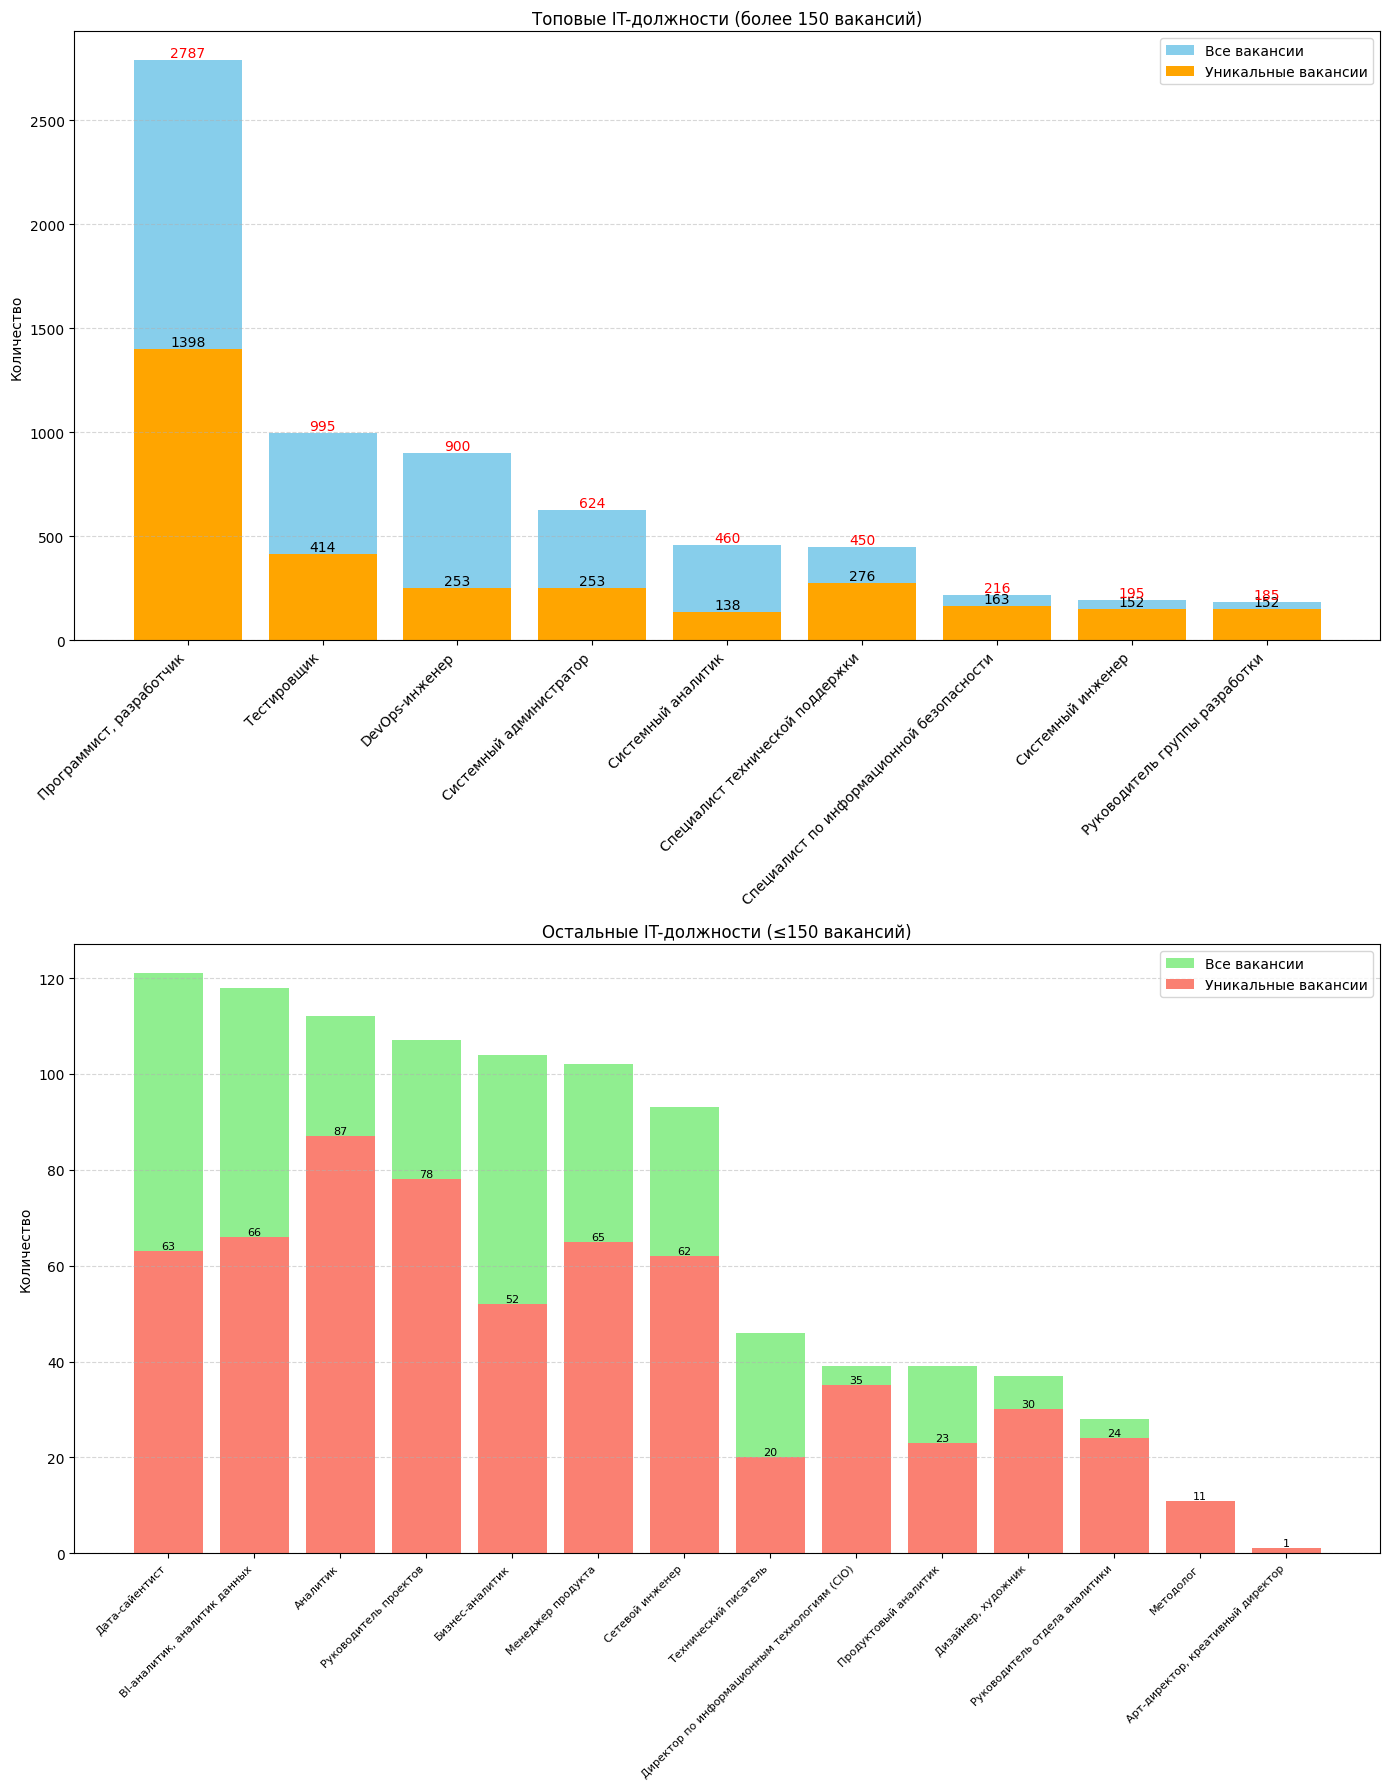

In [202]:

# Группировка данных
grouped = df.groupby('position')['vacancy it'].agg(['nunique', 'count']).sort_values('count', ascending=False)

# Разделение данных на две группы
top_positions = grouped[grouped['count'] > 150]
other_positions = grouped[grouped['count'] <= 150]

# Настройка стиля графиков
plt.figure(figsize=(14, 18))

# --- График 1: Топовые должности (>150 вакансий) ---
plt.subplot(2, 1, 1)
bars = plt.bar(top_positions.index, top_positions['count'], color='skyblue', label='Все вакансии')
plt.bar(top_positions.index, top_positions['nunique'], color='orange', label='Уникальные вакансии')

# Добавляем подписи значений
for bar, uniq, total in zip(bars, top_positions['nunique'], top_positions['count']):
    plt.text(bar.get_x() + bar.get_width()/2, uniq, f"{uniq}", ha='center', va='bottom', color='black')
    plt.text(bar.get_x() + bar.get_width()/2, total, f"{total}", ha='center', va='bottom', color='red')

plt.title('Топовые IT-должности (более 150 вакансий)')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# --- График 2: Остальные должности (≤150 вакансий) ---
plt.subplot(2, 1, 2)
bars = plt.bar(other_positions.index, other_positions['count'], color='lightgreen', label='Все вакансии')
plt.bar(other_positions.index, other_positions['nunique'], color='salmon', label='Уникальные вакансии')

# Подписи значений (только для уникальных, если их мало)
for bar, uniq in zip(bars, other_positions['nunique']):
    if uniq > 0:  # Чтобы не загромождать график
        plt.text(bar.get_x() + bar.get_width()/2, uniq, f"{uniq}", ha='center', va='bottom', fontsize=8)

plt.title('Остальные IT-должности (≤150 вакансий)')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Уменьшаем шрифт, если много позиций
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

##### 2.3 Experience

In [204]:
df['experience'].value_counts(dropna= False)

experience
3–6 лет        2276
Более 6 лет    1851
1–3 года       1723
NaN            1349
Нет опыта       571
Name: count, dtype: int64

In [ ]:
# процесс обработки был на предыдущем этапе 

In [ ]:
#df['experience_norm'] = df['experience'].apply(normalize_experience)


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7770 entries, 0 to 7824
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             7770 non-null   object 
 1   text               7770 non-null   object 
 2   date               5941 non-null   object 
 3   position           7770 non-null   object 
 4   vacancy            7770 non-null   object 
 5   company            7304 non-null   object 
 6   city               5193 non-null   object 
 7   country            7656 non-null   object 
 8   region             5171 non-null   object 
 9   level              7770 non-null   object 
 10  experience         6421 non-null   object 
 11  employment         7544 non-null   object 
 12  schedule           7631 non-null   object 
 13  skills             7770 non-null   object 
 14  salary from        7770 non-null   float64
 15  salary to          7770 non-null   float64
 16  skills_list        7770 non-n

##### 2.5. Level

In [206]:
# обработано на предыдущем этапе

In [ ]:

def plot_salary_from_distribution(df):
    """
    Визуализирует распределение зарплат 'salary from' по уровням
    """
    plt.figure(figsize=(12, 6))
    
    # Фильтруем данные (убираем выбросы и нулевые значения)
    filtered = df[(df['salary from'] < df['salary from'].quantile(0.99)) | (df['level'].isna())]
    filtered = filtered.copy()
    filtered['level'] = filtered['level'].fillna('Unknown')
    levels_order = ['Trainee', 'Junior', 'Middle', 'Lead', 'Senior', 'Unknown']
    
    # Строим boxplot
    sns.violinplot(
        x='level', 
        y='salary from', 
        data=filtered,
        order= levels_order,
        palette='viridis',
        cut=0
    )
    
    plt.title('Распределение зарплат "от" по уровням позиций')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "от" ')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику
    return filtered.groupby('level')['salary from'].describe()

def plot_salary_to_distribution(df):
    """
    Визуализирует распределение зарплат 'salary to ' по уровням
    """
    plt.figure(figsize=(12, 6))
    
    # Фильтруем данные
    filtered = df[(df['salary to'] < df['salary to'].quantile(0.99)) | (df['level'].isna())]
    filtered = filtered.copy()
    filtered['level'] = filtered['level'].fillna('Unknown')
    levels_order = ['Trainee', 'Junior', 'Middle', 'Lead', 'Senior', 'Unknown']
    
    # Строим violin plot для лучшего отображения распределения
    sns.violinplot(
        x='level', 
        y='salary to', 
        data=filtered,
        order=levels_order,
        palette='magma',
        cut=0
    )
    
    plt.title('Распределение зарплат "до" по уровням позиций')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "до" ')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику
    return filtered.groupby('level')['salary to'].describe()

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\2753366437.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




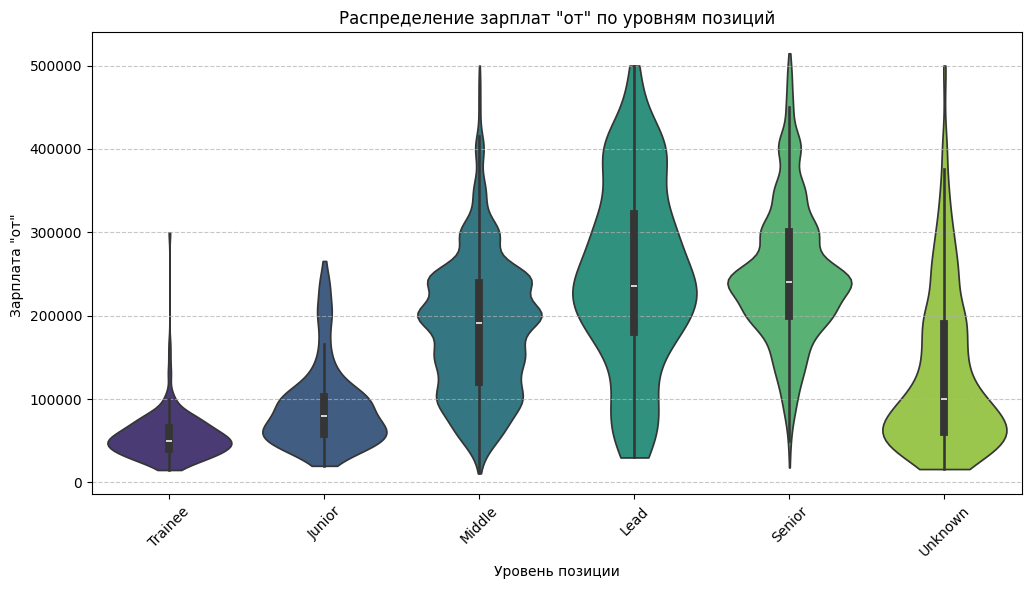

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
Junior,384.0,90651.53,49940.82,20000.0,58363.25,80000.0,102423.0,265623.0
Lead,336.0,248633.62,109698.99,30000.0,180000.00,235819.0,321702.0,500000.0
Middle,4078.0,185467.56,80113.64,11000.0,120000.00,190742.5,239507.0,500000.0
Senior,1970.0,249609.88,80936.11,18000.0,200000.00,240000.0,300000.0,514720.0
Trainee,196.0,55656.98,28565.29,15000.0,40000.00,50000.0,65000.0,300000.0
Unknown,723.0,129946.23,94360.19,16085.0,60000.00,100000.0,190000.0,500000.0


C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\2753366437.py:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




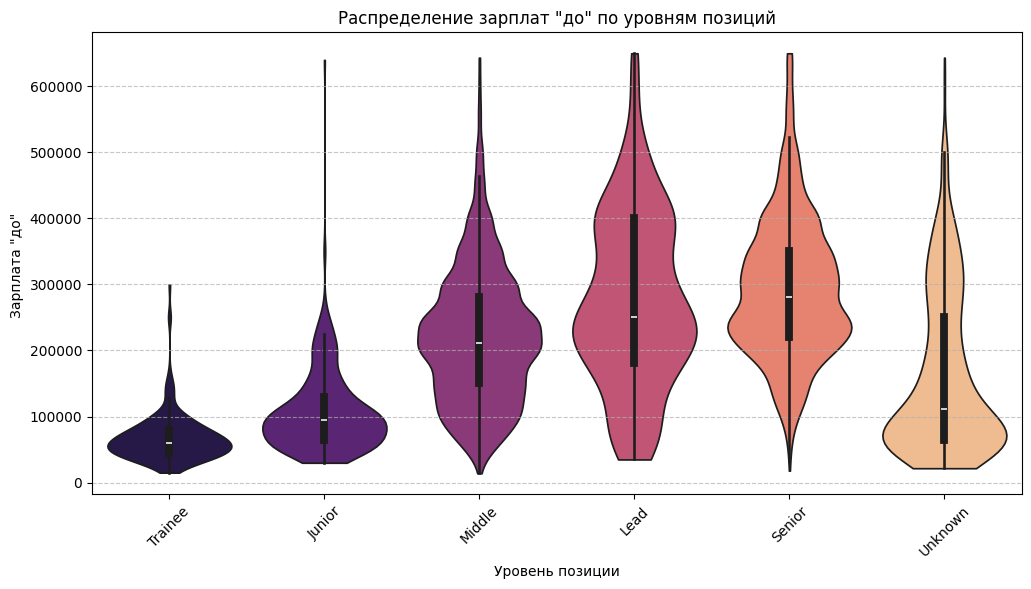

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
Junior,385.0,106638.12,61159.87,30000.0,65000.0,95000.0,130000.0,640000.0
Lead,335.0,274558.78,132325.48,35000.0,181774.5,250000.0,400000.0,650000.0
Middle,4077.0,221792.67,102072.77,14000.0,150000.0,211423.0,281490.0,643405.0
Senior,1976.0,293697.51,106790.61,18000.0,220000.0,281490.0,350000.0,650000.0
Trainee,196.0,67806.91,36565.01,15000.0,45450.0,60000.0,80000.0,300000.0
Unknown,723.0,164906.05,123622.29,21715.0,65000.0,111819.0,250000.0,643405.0


In [215]:
# Для зарплат "от"
stats_from = plot_salary_from_distribution(df)
display(stats_from.round({'mean': 2, 'std': 2}))

# Для зарплат "до" 
stats_to = plot_salary_to_distribution(df)
display(stats_to.round({'mean': 2, 'std': 2}))

In [231]:
df['level'].value_counts(dropna=False)

level
Middle     4103
Senior     2016
Unknown     727
Junior      385
Lead        343
Trainee     196
Name: count, dtype: int64

##### 2.4 City, Country, employment, schedule

In [216]:
df['city'].value_counts(dropna=False)

city
Москва               2703
NaN                  2577
Санкт Петербург       585
Казань                143
Екатеринбург          131
                     ... 
Совхоз Им. Ленина       1
Городище                1
Северобайкальск         1
Дмитров                 1
Республика Крым         1
Name: count, Length: 265, dtype: int64

In [217]:
df['country'].value_counts(dropna=False)

country
Россия    7656
NaN        114
Name: count, dtype: int64

In [218]:
df['employment'].value_counts(dropna=False)

employment
Полная занятость       7127
Частичная занятость     330
NaN                     226
Проектная работа         87
Name: count, dtype: int64

In [219]:
df['schedule'].value_counts(dropna=False)

schedule
Удаленная работа    3202
Гибкий график       2577
Полный день         1595
Сменный график       253
NaN                  139
Вахтовый метод         4
Name: count, dtype: int64

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7770 entries, 0 to 7824
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             7770 non-null   object 
 1   text               7770 non-null   object 
 2   date               5941 non-null   object 
 3   position           7770 non-null   object 
 4   vacancy            7770 non-null   object 
 5   company            7304 non-null   object 
 6   city               5193 non-null   object 
 7   country            7656 non-null   object 
 8   region             5171 non-null   object 
 9   level              7770 non-null   object 
 10  experience         6421 non-null   object 
 11  employment         7544 non-null   object 
 12  schedule           7631 non-null   object 
 13  skills             7770 non-null   object 
 14  salary from        7770 non-null   float64
 15  salary to          7770 non-null   float64
 16  skills_list        7770 non-n

#### 2.5. Region

In [221]:
df_copy=df

In [ ]:
'''
df_region = pd.DataFrame({'city': sorted(df[df['country'] == 'Россия']['city'].dropna().unique())})
df_region.loc[:, 'region'] = np.nan
df_region.info()
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    476 non-null    object 
 1   region  0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [ ]:
#регионы отработаны на предыдущем этапе

In [ ]:
#df_mapped = pd.read_csv('data/df_region.csv')  # ← Файл с заполненными регионами

In [223]:
with pd.option_context('display.max_rows', 100):
    display(df['region'].value_counts(dropna=False))

region
Москва                                                            2724
NaN                                                               2599
Санкт-Петербург                                                    596
Татарстан                                                          146
Свердловская область                                               136
Новосибирская область                                              123
Краснодарский край                                                 111
Московская область                                                  91
Ростовская область                                                  82
Нижегородская область                                               76
Любой регион                                                        75
Самарская область                                                   57
Приморский край                                                     53
Воронежская область                                                 53

In [224]:
# Посмотрим на регионы с Nan и Удаленной работой
mask = (df['region'].isna()) & (df['schedule'] == 'Удаленная работа')
df[mask].shape[0]

2243

In [225]:
df.loc[mask, 'region'] = 'Любой регион'

In [228]:
df['region'].value_counts(dropna=False)

region
Москва                                 2724
Любой регион                           2318
Санкт-Петербург                         596
NaN                                     356
Татарстан                               146
                                       ... 
Республика Северная Осетия — Алания       1
Карачаево-Черкесия                        1
Республика Алтай                          1
Ямало-Ненецкий автономный округ           1
Еврейская автономная область              1
Name: count, Length: 86, dtype: int64

In [229]:
df['country'].value_counts()

country
Россия    7656
Name: count, dtype: int64

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7770 entries, 0 to 7824
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             7770 non-null   object 
 1   text               7770 non-null   object 
 2   date               5941 non-null   object 
 3   position           7770 non-null   object 
 4   vacancy            7770 non-null   object 
 5   company            7304 non-null   object 
 6   city               5193 non-null   object 
 7   country            7656 non-null   object 
 8   region             7414 non-null   object 
 9   level              7770 non-null   object 
 10  experience         6421 non-null   object 
 11  employment         7544 non-null   object 
 12  schedule           7631 non-null   object 
 13  skills             7770 non-null   object 
 14  salary from        7770 non-null   float64
 15  salary to          7770 non-null   float64
 16  skills_list        7770 non-n

#### 3. EDA

##### 3.1. Salary

,is_normal_salary from,is_normal_salary to,n_removed_salary from,n_removed_salary to,n_total_salary from,n_total_salary to,p_value_salary from,p_value_salary to
position,,,,,,,,
"BI-аналитик, аналитик данных",True,False,0,6,118,118,0.163438,0.001855
DevOps-инженер,False,False,12,28,900,900,0.0,0.0
Аналитик,False,False,5,1,112,112,0.011663,0.012186
"Арт-директор, креативный директор",too_small,too_small,0,0,1,1,NaN,NaN
Бизнес-аналитик,True,True,1,0,104,104,0.074581,0.077854
Дата-сайентист,False,False,1,6,121,121,0.003679,0.0
"Дизайнер, художник",False,False,1,1,37,37,0.0,0.0
Директор по информационным технологиям (CIO),False,False,2,3,39,39,0.0,0.0
Менеджер продукта,False,False,7,9,102,102,0.0,0.0


C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\1826345095.py:91: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\1826345095.py:91: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

c:\Users\Андрей\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



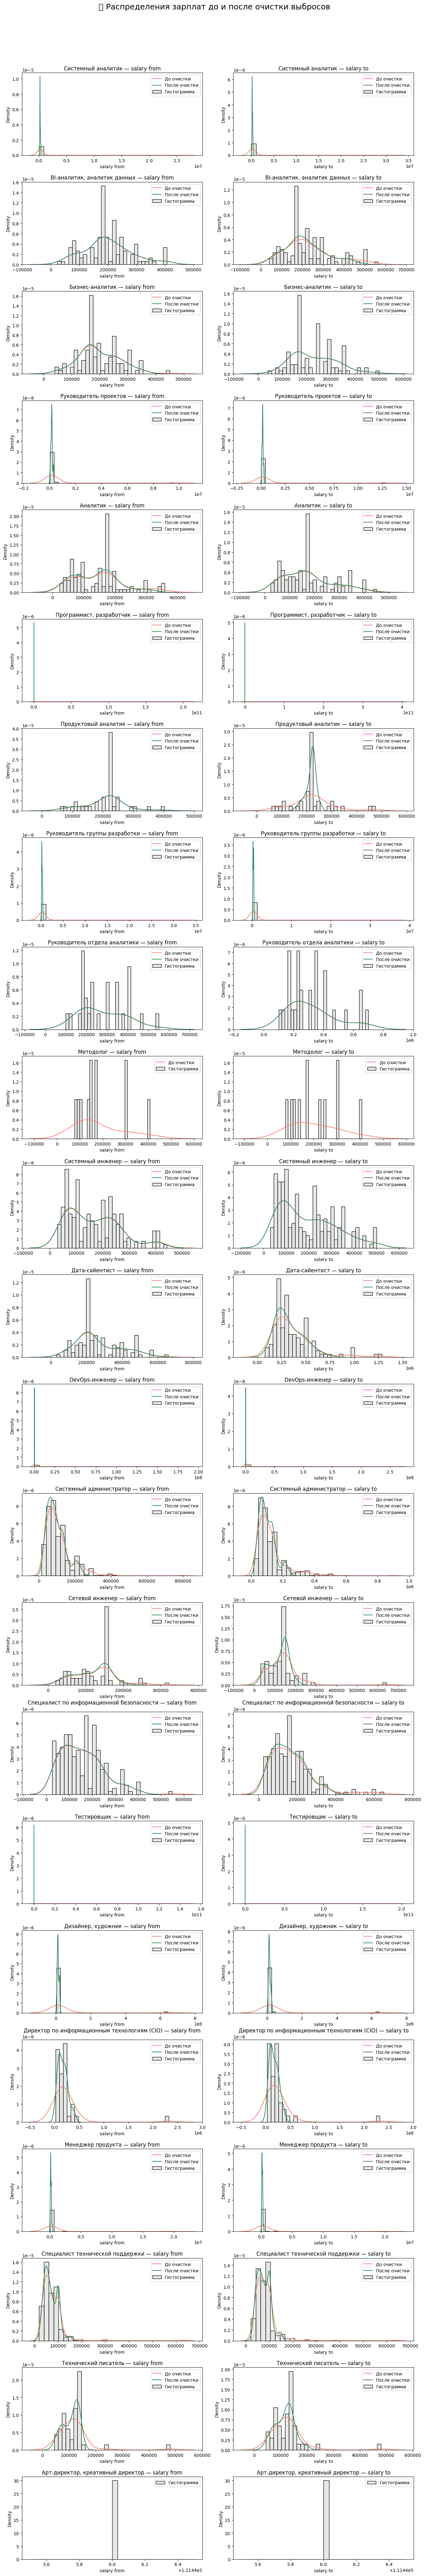

In [232]:

from scipy.stats import normaltest

# Создаём копию безопасно
df_copy = df.copy()

# Создаём колонки для нормализованных значений
df.loc[:, 'salary from norm'] = np.nan
df.loc[:, 'salary to norm'] = np.nan

# Для сбора отчёта
report = []

# Функция очистки и нормализации
def process_series(series, colname, position):
    series = pd.to_numeric(series, errors='coerce')
    series = series.dropna()
    n_total = len(series)

    if n_total <= 20:
        report.append({
            'position': position,
            'column': colname,
            'is_normal': 'too_small',
            'n_total': n_total,
            'n_filtered': n_total,
            'n_removed': 0,
            'p_value': np.nan
        })
        return None  # потом заменим

    stat, p = normaltest(series)
    is_normal = p > 0.05

    if is_normal:
        mu, sigma = series.mean(), series.std()
        mask = (series >= mu - 3 * sigma) & (series <= mu + 3 * sigma)
    else:
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        mask = (series >= q1 - 1.5 * iqr) & (series <= q3 + 1.5 * iqr)

    n_filtered = mask.sum()
    n_removed = n_total - n_filtered

    report.append({
        'position': position,
        'column': colname,
        'is_normal': is_normal,
        'n_total': n_total,
        'n_filtered': n_filtered,
        'n_removed': n_removed,
        'p_value': p
    })

    return series[mask]

# Обработка по каждой позиции
positions = df['position'].dropna().unique()

for pos in positions:
    mask_pos = df['position'] == pos
    for col in ['salary from', 'salary to']:
        clean_series = process_series(df.loc[mask_pos, col], col, pos)
        if clean_series is not None:
            index_valid = clean_series.index
            df.loc[index_valid, f'{col} norm'] = clean_series

# Собираем и форматируем отчёт
report_df = pd.DataFrame(report)

# Сводная таблица
report_summary = report_df.pivot(index='position', columns='column', values=['is_normal', 'n_removed', 'n_total', 'p_value'])
report_summary.columns = ['_'.join(col).strip() for col in report_summary.columns.values]

# Показываем таблицу
display(report_summary)

# Визуализация распределений
n_positions = len(positions)
fig, axs = plt.subplots(n_positions, 2, figsize=(14, n_positions * 3.5))
fig.tight_layout(pad=4)

for idx, pos in enumerate(positions):
    for j, col in enumerate(['salary from', 'salary to']):
        ax = axs[idx][j] if n_positions > 1 else axs[j]
        before = df[df_copy['position'] == pos][col]
        after = df[df_copy['position'] == pos][f'{col} norm']

        sns.histplot(before, ax=ax, bins=30, stat='density', color='lightgray', alpha=0.5, label='Гистограмма')
        sns.kdeplot(before, ax=ax, color='salmon', label='До очистки')
        sns.kdeplot(after.dropna(), ax=ax, color='seagreen', label='После очистки')

        ax.set_title(f"{pos} — {col}")
        ax.legend()

plt.suptitle("📊 Распределения зарплат до и после очистки выбросов", fontsize=18, y=1.02)
plt.show()


In [233]:
for pos in positions:
    pos_mask = df['position'] == pos

    for col in ['salary from', 'salary to']:
        # очищаем колонку от выбросов
        cleaned_series = process_series(
            df_copy.loc[pos_mask, col],
            col,
            pos
        )

        # сохраняем очищенные значения в новую колонку
        df.loc[pos_mask, f'{col} norm'] = cleaned_series

In [234]:
df_copy = df.copy()

In [372]:
#df = df_copy

In [235]:
df = df.dropna(subset=['salary from norm', 'salary to norm'], how='any')

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7368 entries, 0 to 7824
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             7368 non-null   object 
 1   text               7368 non-null   object 
 2   date               5582 non-null   object 
 3   position           7368 non-null   object 
 4   vacancy            7368 non-null   object 
 5   company            6939 non-null   object 
 6   city               5006 non-null   object 
 7   country            7256 non-null   object 
 8   region             7051 non-null   object 
 9   level              7368 non-null   object 
 10  experience         6106 non-null   object 
 11  employment         7148 non-null   object 
 12  schedule           7230 non-null   object 
 13  skills             7368 non-null   object 
 14  salary from        7368 non-null   float64
 15  salary to          7368 non-null   float64
 16  skills_list        7368 non-n

##### 3.2 Level

In [237]:
df['level'].value_counts()

level
Middle     3940
Senior     1836
Unknown     697
Junior      378
Lead        322
Trainee     195
Name: count, dtype: int64

In [240]:

def plot_salary_from_distribution(df):
    """
    Визуализирует распределение зарплат 'salary from norm' по уровням
    """
    plt.figure(figsize=(12, 6))
    
    # Фильтруем данные (убираем выбросы и нулевые значения)
    filtered = df
    filtered = filtered.copy()
    filtered['level'] = filtered['level'].fillna('Unknown')
    levels_order = ['Trainee', 'Junior', 'Middle', 'Lead', 'Senior', 'Unknown']
    
    # Строим boxplot
    sns.violinplot(
        x='level', 
        y='salary from norm', 
        data=filtered,
        order= levels_order,
        palette='viridis',
        cut=0
    )
    
    plt.title('Распределение зарплат "от" по уровням позиций')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "от" ')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику
    return filtered.groupby('level')['salary from norm'].describe()

def plot_salary_to_distribution(df):
    """
    Визуализирует распределение зарплат 'salary to norm ' по уровням
    """
    plt.figure(figsize=(12, 6))
    
    # Фильтруем данные
    filtered = df
    filtered = filtered.copy()
    filtered['level'] = filtered['level'].fillna('Unknown')
    levels_order = ['Trainee', 'Junior', 'Middle', 'Lead', 'Senior', 'Unknown']
    
    # Строим violin plot для лучшего отображения распределения
    sns.violinplot(
        x='level', 
        y='salary to norm', 
        data=filtered,
        order=levels_order,
        palette='magma',
        cut=0
    )
    
    plt.title('Распределение зарплат "до" по уровням позиций')
    plt.xlabel('Уровень позиции')
    plt.ylabel('Зарплата "до" ')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Возвращаем статистику
    return filtered.groupby('level')['salary to norm'].describe()

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\4170792203.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




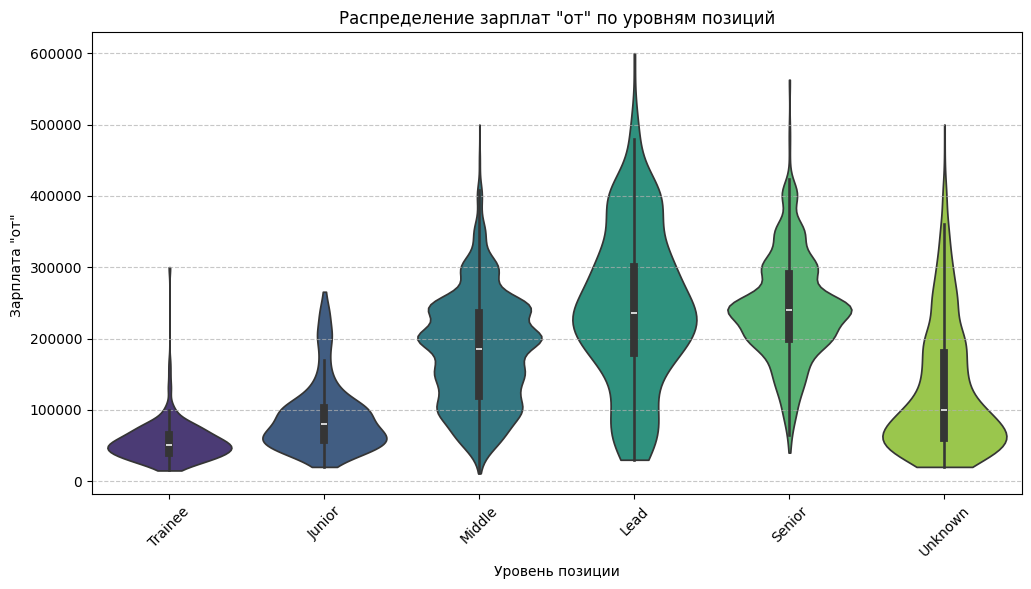

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
Junior,378.0,90395.25,49612.43,20000.0,57089.75,80000.0,102423.0,265623.0
Lead,322.0,242802.46,108450.76,30000.0,179017.00,235819.0,300000.0,600000.0
Middle,3940.0,182460.35,76104.98,11000.0,120000.00,185000.0,235819.0,500000.0
Senior,1836.0,241617.86,73259.56,40000.0,200000.00,239507.0,290000.0,562979.0
Trainee,195.0,55634.71,28637.12,15000.0,40000.00,50000.0,65000.0,300000.0
Unknown,697.0,126658.87,89119.01,20000.0,60000.00,100000.0,180000.0,500000.0


C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\4170792203.py:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




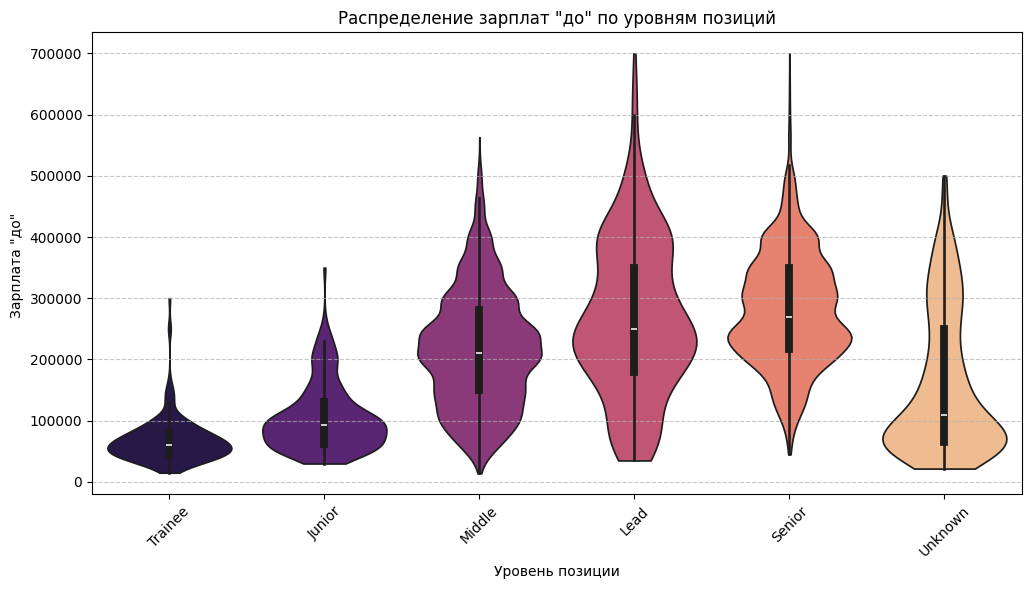

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
Junior,378.0,105118.77,54647.33,30000.0,61250.0,93500.0,129990.5,350000.0
Lead,322.0,266142.85,127385.57,35000.0,180000.0,250000.0,350000.0,700000.0
Middle,3940.0,216440.54,94922.07,14000.0,150000.0,210000.0,280000.0,562979.0
Senior,1836.0,280505.24,92172.43,45000.0,217820.0,270000.0,350000.0,700000.0
Trainee,195.0,67846.94,36654.82,15000.0,45300.0,60000.0,80000.0,300000.0
Unknown,697.0,159669.57,116716.32,21715.0,65000.0,110000.0,250000.0,500000.0


In [241]:
# Для зарплат "от"
stats_from = plot_salary_from_distribution(df)
display(stats_from.round({'mean': 2, 'std': 2}))

# Для зарплат "до" 
stats_to = plot_salary_to_distribution(df)
display(stats_to.round({'mean': 2, 'std': 2}))

In [378]:
# Для начала заполним level из experience level там где не определено нашей регуляркой

In [382]:
#df = df_copy

In [243]:
df['experience'].value_counts(dropna=False)

experience
3–6 лет        2178
Более 6 лет    1690
1–3 года       1674
NaN            1262
Нет опыта       564
Name: count, dtype: int64

In [247]:
len(unknown_exp)

697

In [248]:
unknown_exp['experience'].value_counts(dropna=False)

experience
Unknown        272
1–3 года       218
Нет опыта      160
3–6 лет         46
Более 6 лет      1
Name: count, dtype: int64

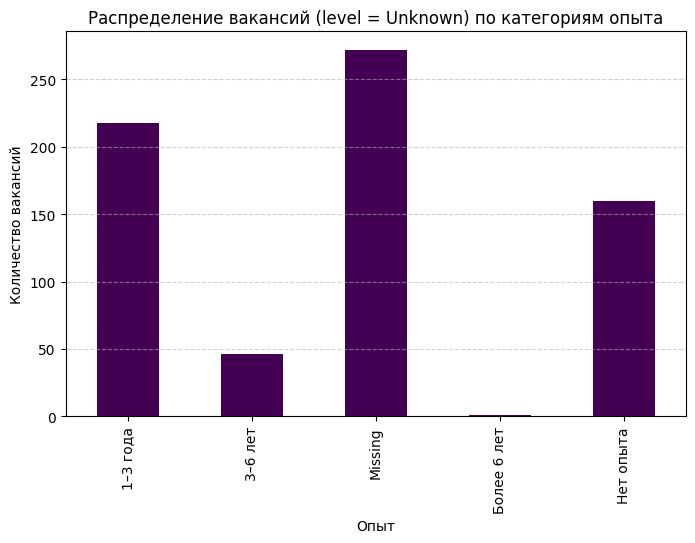

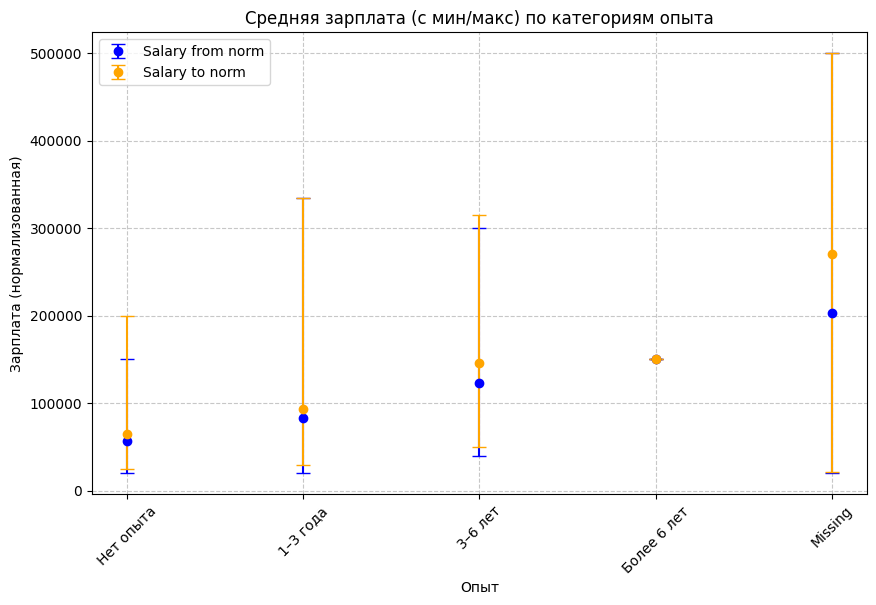

In [256]:
import seaborn as sns
import matplotlib.pyplot as plt

unknown_exp = df[df['level'] == 'Unknown'].copy()

# заполняем NaN и приводим к строкам
unknown_exp['experience'] = unknown_exp['experience'].fillna('Missing').astype(str)

# Объединяем категории "Более 6 лет" и "3–6 лет"
#unknown_exp.loc[unknown_exp['experience'] == 'Более 6 лет', 'experience'] = '3–6 лет'

# Обновляем exp_order
exp_order = ['Нет опыта', '1–3 года', '3–6 лет','Более 6 лет', 'Missing']

# оставляем только допустимые категории
unknown_exp = unknown_exp[unknown_exp['experience'].isin(exp_order)]

plt.figure(figsize=(10, 10))
# График с использованием Plotly
ax = unknown_exp['experience'].value_counts().sort_index().plot(kind='bar', figsize=(8, 5), colormap='viridis')
ax.set_title('Распределение вакансий (level = Unknown) по категориям опыта')
ax.set_xlabel('Опыт')
ax.set_ylabel('Количество вакансий')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()



# 2️⃣ Мин/макс + среднее salary_from_norm и salary_to_norm по experience
salary_stats = df[df['level'] == 'Unknown'].copy()
salary_stats['experience'] = salary_stats['experience'].fillna('Missing')

agg_stats = salary_stats.groupby('experience')[['salary from norm', 'salary to norm']].agg(['mean', 'min', 'max']).reset_index()

# Удобные названия колонок
agg_stats.columns = ['experience',
                     'from_mean', 'from_min', 'from_max',
                     'to_mean', 'to_min', 'to_max']

# Сохраняем порядок категорий
agg_stats['experience'] = pd.Categorical(agg_stats['experience'], categories=exp_order, ordered=True)
agg_stats = agg_stats.sort_values('experience')

# 🎯 Errorbar-график
plt.figure(figsize=(10, 6))

x_labels = agg_stats['experience'].astype(str)   # ось X в строках
x_pos = range(len(x_labels))                     # позиции по оси X

# Salary from
plt.errorbar(x_pos, agg_stats['from_mean'],
             yerr=[agg_stats['from_mean'] - agg_stats['from_min'],
                   agg_stats['from_max'] - agg_stats['from_mean']],
             fmt='o', capsize=5, label='Salary from norm', color='blue')

# Salary to
plt.errorbar(x_pos, agg_stats['to_mean'],
             yerr=[agg_stats['to_mean'] - agg_stats['to_min'],
                   agg_stats['to_max'] - agg_stats['to_mean']],
             fmt='o', capsize=5, label='Salary to norm', color='orange')

plt.xticks(x_pos, x_labels, rotation=45)   # подписи категорий
plt.title('Средняя зарплата (с мин/макс) по категориям опыта')
plt.xlabel('Опыт')
plt.ylabel('Зарплата (нормализованная)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [257]:
df[(df['level'] == 'Unknown') & (df['experience'] == 'Более 6 лет')]

,source,text,date,position,vacancy,company,city,country,region,level,...,skills_list,skills_clean,skills_clean_norm,skills_count,vacancy_norm,vacancy_info,is_it,vacancy it,salary from norm,salary to norm
5676,finder,"Обязанности: Настройка программ 1С, различных ...",NaN,"Программист, разработчик",Программист 1С,"ООО ""ММЦ Здоровье""",Екатеринбург,Россия,Свердловская область,Unknown,...,"[1С, Bitrix 24]","[1С, Bitrix 24]","[1с, Bitrix 24]",2,Программист 1С,,True,Программист 1С,150000.0,150000.0


In [258]:
df[df['level'] == 'Unknown'].shape

(697, 26)

In [259]:
# Тут можно вернуться и сделать мапинг Без опыта - Junior / 1-3 Middle



In [ ]:
# нужно посмотреть на аномальные для категории строчки и понять в чем проблема 

# начнем с salary from norm

# junior
mask = (df['level'] == 'Junior') & (df['salary from norm'] > 200000)
df[mask][['source','text','vacancy it','city','level', 'experience','skills_list', 'skills_clean_norm','salary from norm']]
'''
with pd.option_context(
    'display.max_rows', None,          # Показать все строки
    'display.max_columns', None,       # Показать все столбцы
    'display.max_colwidth', None       # Полный текст в ячейках
):

    display(df[mask][['source','text','vacancy it','city','level', 'experience','skills_list', 'skills_clean_norm','salary from norm']])
'''

In [265]:
# гипотиза для правки 
df[(df['experience'] == '3–6 лет') & (df['level'] == 'Junior')]

,source,text,date,position,vacancy,company,city,country,region,level,...,skills_list,skills_clean,skills_clean_norm,skills_count,vacancy_norm,vacancy_info,is_it,vacancy it,salary from norm,salary to norm
3669,qa_jobs_messages,#вакансия #ГородМосква #QA #junior\n\n💻Должнос...,2025-05-07T11:46:49+00:00,Тестировщик,QA junior,Devquality,Москва,Россия,Москва,Junior,...,"[написание тест-кейсов, функциональное тестиро...","[написание тест-кейсов, функциональное тестиро...","[Работа с базами данных, работа с TMS, работа ...",12,QA junior,,True,QA junior,80000.0,80000.0


In [ ]:
# здесь пытаемся отсечь явные несоответствия всем категориям level
with pd.option_context(
    'display.max_rows', None,          # Показать все строки
    'display.max_columns', None,       # Показать все столбцы
    'display.max_colwidth', None       # Полный текст в ячейках
):
    mask = (df['level'] == 'Senior') & (df['salary from norm'] < 100000)
    display(df[mask].shape[0])
    
    display(df[mask])

In [271]:
mask = (df['level'] == 'Senior') & (df['salary from norm'] < 100000)
df.loc[mask, 'level'] = 'Unknown'

In [ ]:
#df_copy = df

In [ ]:
# здесь пытаемся отсечь явные несоответствия всем категориям level
with pd.option_context(
    'display.max_rows', None,          # Показать все строки
    'display.max_columns', None,       # Показать все столбцы
    'display.max_colwidth', None       # Полный текст в ячейках
):
    mask = (df['level'] == 'Middle') & (df['salary from norm'] < 50000)
    display(df[mask].shape[0])
    
    display(df[mask])

In [277]:
mask = (df['level'] == 'Middle') & (df['salary from norm'] < 50000)
df.loc[mask, 'level'] = 'Unknown'

In [279]:
mask = (df['level'] == 'Lead') & (df['salary from norm'] < 80000)
df.loc[mask, 'level'] = 'Unknown'

In [ ]:
mask = (df['level'] == 'Trainee') & (df['salary from norm'] > 200000)
display(df[mask].shape[0])

1

In [282]:
mask = (df['level'] == 'Trainee') & (df['salary from norm'] >200000)
df.loc[mask, 'level'] = 'Unknown'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\4170792203.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




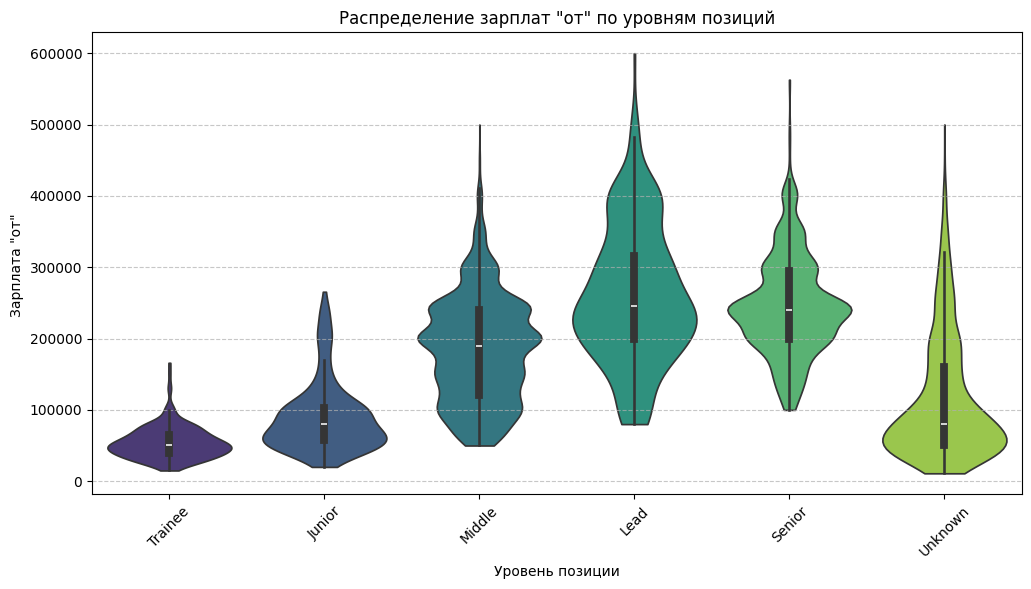

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
Junior,378.0,90395.251323,49612.433971,20000.0,57089.75,80000.0,102423.0,265623.0
Lead,295.0,260147.193220,96040.812683,80000.0,200000.00,246102.0,315851.0,600000.0
Middle,3881.0,184675.175728,74506.499550,50000.0,120638.00,190000.0,239507.0,500000.0
Senior,1798.0,245101.407119,69919.144928,100000.0,200000.00,239507.0,295000.0,562979.0
Trainee,194.0,54375.097938,22656.955772,15000.0,40000.00,50000.0,65000.0,166000.0
Unknown,822.0,115702.773723,86863.251509,11000.0,50000.00,80000.0,160000.0,500000.0


C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\4170792203.py:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




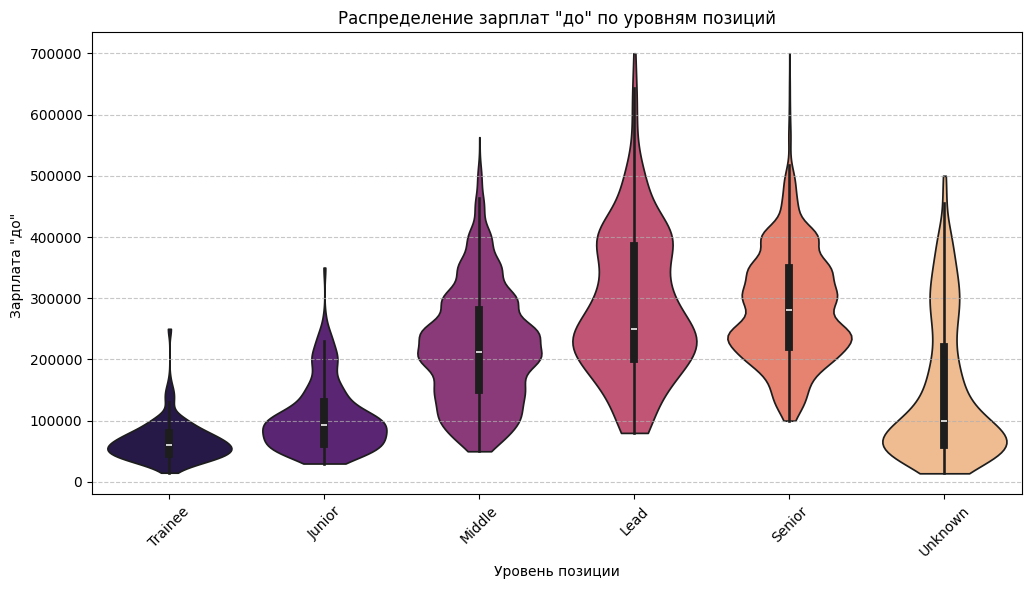

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
Junior,378.0,105118.767196,54647.327365,30000.0,61250.0,93500.0,129990.5,350000.0
Lead,295.0,284871.277966,116069.344270,80000.0,200487.0,250000.0,385000.0,700000.0
Middle,3881.0,218856.957228,93359.234801,50000.0,150000.0,211423.0,280000.0,562979.0
Senior,1798.0,284026.860400,89358.228309,100000.0,220000.0,280000.0,350000.0,700000.0
Trainee,194.0,66650.278351,32708.545312,15000.0,45150.0,60000.0,80000.0,250000.0
Unknown,822.0,147165.288321,113979.802615,14000.0,60000.0,100000.0,220000.0,500000.0


In [283]:
# Для зарплат "от"
stats_from = plot_salary_from_distribution(df)
display(stats_from)

# Для зарплат "до" 
stats_to = plot_salary_to_distribution(df)
display(stats_to)

In [399]:
# Попробуем избавиться от высоких з/п с level no

# начнем с salary from norm

# junior
mask = (df['level'] == 'no') & (df['salary to norm'] > 300000)
df[mask]

,position,date,vacancy,company,city,experience,employment,schedule,salary from,salary to,...,skills_count,vacancy_norm,vacancy_info,is_it,vacancy it,experience_norm,region,salary from norm,salary to norm,level_copy


In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7368 entries, 0 to 7824
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             7368 non-null   object 
 1   text               7368 non-null   object 
 2   date               5582 non-null   object 
 3   position           7368 non-null   object 
 4   vacancy            7368 non-null   object 
 5   company            6939 non-null   object 
 6   city               5006 non-null   object 
 7   country            7256 non-null   object 
 8   region             7051 non-null   object 
 9   level              7368 non-null   object 
 10  experience         6106 non-null   object 
 11  employment         7148 non-null   object 
 12  schedule           7230 non-null   object 
 13  skills             7368 non-null   object 
 14  salary from        7368 non-null   float64
 15  salary to          7368 non-null   float64
 16  skills_list        7368 non-n

In [275]:
df['schedule'].value_counts()

schedule
Удаленная работа    2988
Гибкий график       2458
Полный день         1535
Сменный график       246
Вахтовый метод         3
Name: count, dtype: int64

In [402]:
#df.to_csv('data/stage_3_df_to_model.csv', index=False)

#### 3.4 Skills

In [285]:
# Статистика по position
stats = df.groupby('position').agg(
    total_rows=('position', 'count'),  # Общее количество строк
    vacancy_count=('vacancy it', 'nunique'),  # Количество уникальных вакансий
    unique_skills=('skills_clean_norm', lambda x: x.explode().nunique())  # Уникальные навыки
).sort_values('total_rows', ascending=False)

# Настройки отображения
with pd.option_context('display.max_rows', None,
                      'display.float_format', '{:.0f}'.format):
    display(stats)

,total_rows,vacancy_count,unique_skills
position,,,
"Программист, разработчик",2639,1327,5461
Тестировщик,979,408,1965
DevOps-инженер,869,243,1534
Системный администратор,567,230,2546
Специалист технической поддержки,437,266,1324
Системный аналитик,412,116,1078
Специалист по информационной безопасности,208,159,810
Системный инженер,194,152,863
Руководитель группы разработки,178,147,560


In [416]:
#df_llm = pd.read_csv('df_vac_checked_stage_3')

In [286]:
top_positions = stats.head(25).reset_index()

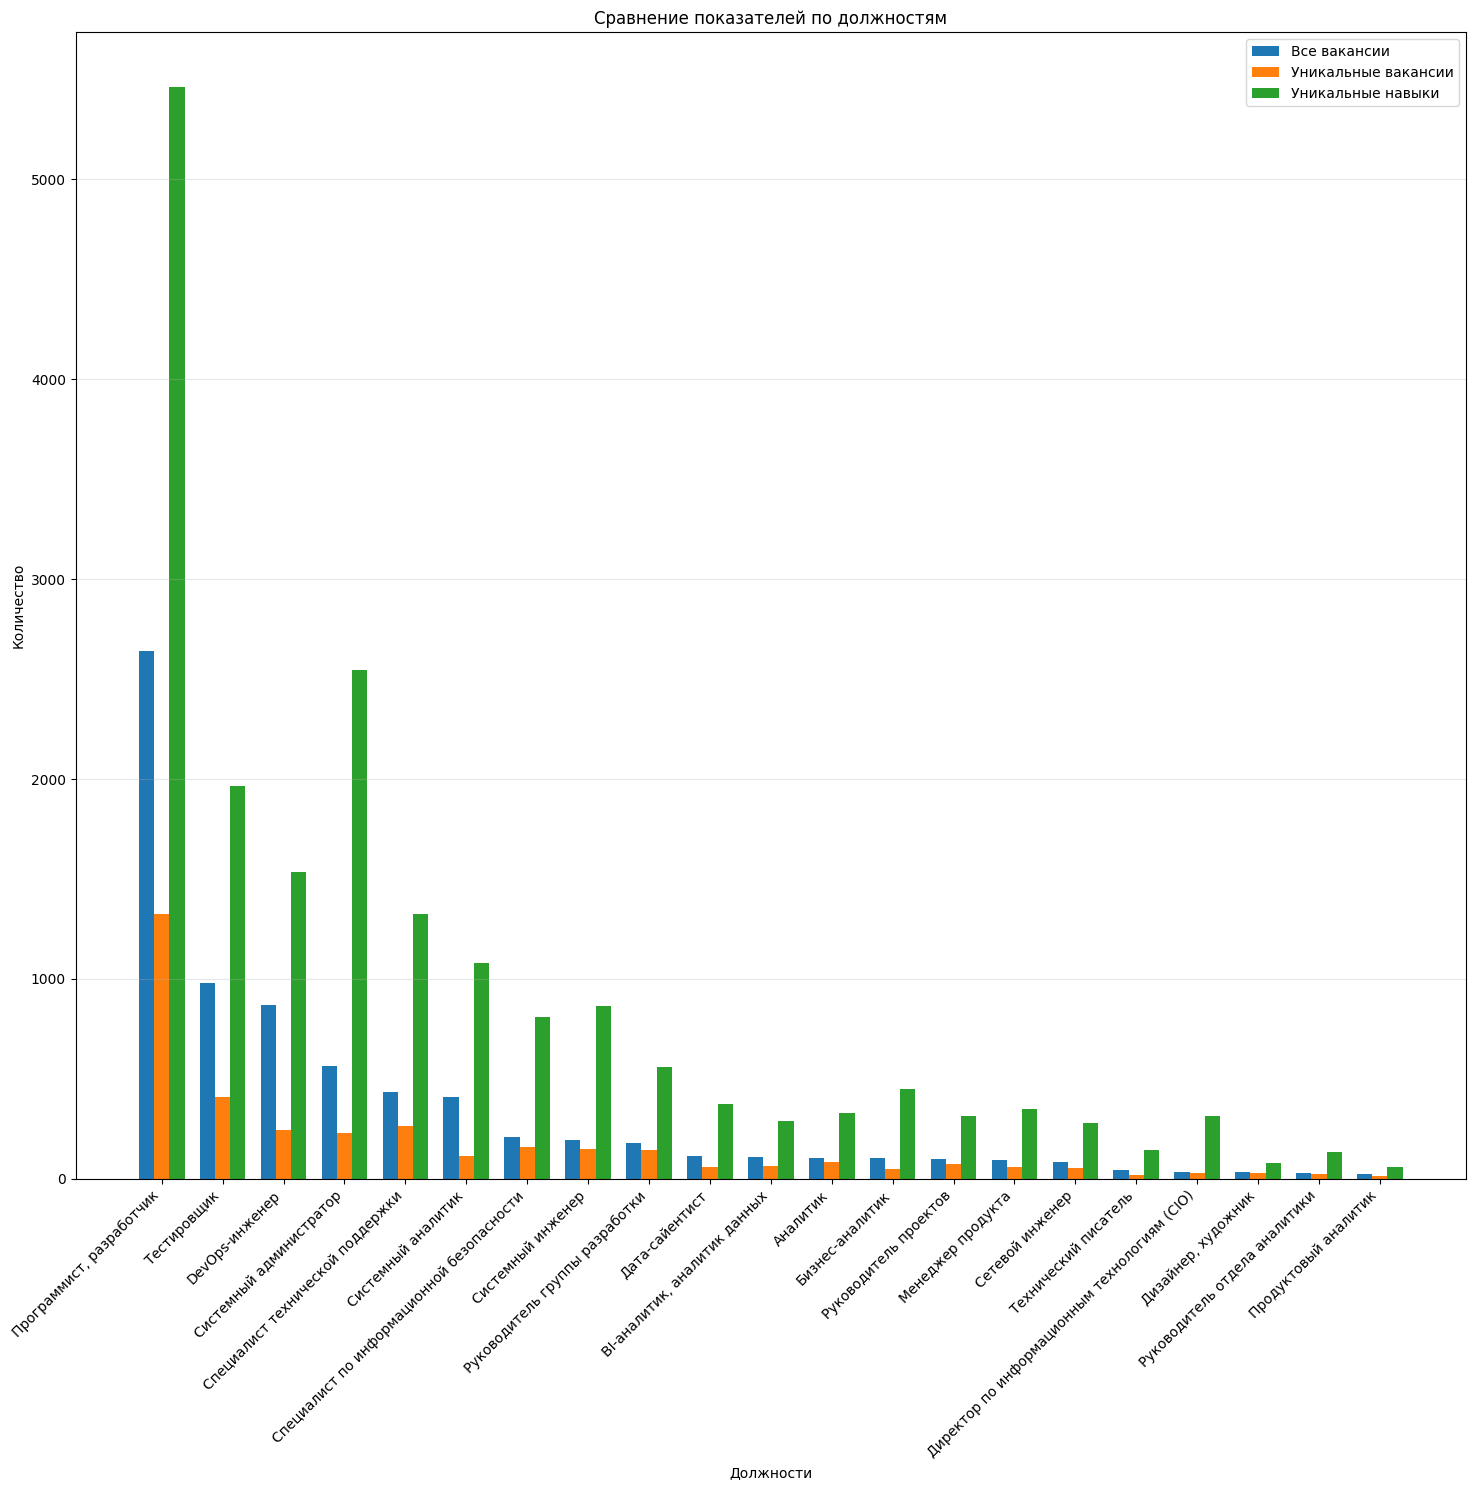

In [287]:
x = range(len(top_positions))
width = 0.25
plt.figure(figsize=(15, 15))
plt.bar(x, top_positions['total_rows'], width, label='Все вакансии')
plt.bar([i + width for i in x], top_positions['vacancy_count'], width, label='Уникальные вакансии')
plt.bar([i + 2*width for i in x], top_positions['unique_skills'], width, label='Уникальные навыки')

plt.title('Сравнение показателей по должностям')
plt.xlabel('Должности')
plt.ylabel('Количество')
plt.xticks([i + width for i in x], top_positions['position'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [419]:
def get_top_skills_by_position(df, position_name, feature, top_n=None):
    """
    Возвращает список навыков для указанной должности, отсортированный по частоте встречаемости
    
    Параметры:
    ----------
    df : DataFrame
        Исходный датафрейм с вакансиями
    position_name : str
        Название должности для фильтрации (например, 'Data Scientist')
    top_n : int, optional
        Количество возвращаемых навыков (по умолчанию - все)
    
    Возвращает:
    -----------
    Series
        Серия с навыками и их частотой, отсортированная по убыванию
    """
    # Фильтруем по должности и "разворачиваем" списки навыков
    skills_series = df[df['position'] == position_name][feature].explode()
    
    # Считаем частотность и сортируем
    skills_counts = skills_series.value_counts()
    
    # Возвращаем либо топ-N, либо все навыки
    return skills_counts.head(top_n) if top_n else skills_counts

In [ ]:
py_dev_skills = get_top_skills_by_position(df, 'Дата-сайентист', 'skills_clean_norm', top_n=345
                                           )
display(HTML(py_dev_skills.to_frame().to_html()))


In [288]:
all_skills = flatten_skills(df['skills_clean_norm'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

14685

In [289]:


from rapidfuzz import fuzz, process
from tqdm import tqdm
import re

def split_compound_skill(skill):
    """
    Улучшенное разбиение составных навыков с сохранением структуры
    """
    # Если есть явные разделители с перечислением технологий
    if any(sep in skill for sep in [', ', ' / ', '; ']):
        # Разбиваем по разделителям, сохраняя основную категорию
        parts = re.split(r'(, | / |; )', skill)
        # Основная категория - часть до первого разделителя
        main_part = parts[0].strip()
        # Технологии - все остальные части
        techs = [p.strip() for p in parts[2::2] if p.strip()]
        return main_part, techs
    return skill, []


def is_multi_word_skill(skill):
    """
    Проверяет, является ли навык сложным (состоит из нескольких слов ИЛИ содержит важные спецсимволы)
    с учетом особенностей формулировок
    """
    normalized = normalize_skill_for_matching(skill)
    
    # Считаем навык сложным если:
    # 1. Содержит дефис/подчеркивание/точку (кроме разделителей)
    if re.search(r'[-\_.](?![-\_])', normalized):
        return True
    # 2. Явно состоит из нескольких слов
    if len(normalized.split()) > 1:
        return True
    # 3. Содержит CamelCase (кириллица или латиница)
    if re.search(r'([А-ЯЁA-Z][а-яёa-z])', skill):  # Проверяем оригинальный регистр
        return True
    return False
    
    
def normalize_skill_for_matching(skill):
    """
    Безопасная нормализация для сравнения навыков:
    - Сохраняет оригинальные пробелы внутри названия
    - Сохраняет специальные символы (дефисы, точки) внутри названия
    - Удаляет только разделители (/,) используемые для перечисления
    """
    skill = skill.strip().lower()
    # Заменяем только явные разделители с пробелами вокруг
    skill = re.sub(r'\s*[/,]\s*', ' ', skill)
    # Удаляем только лишние пробелы (но сохраняем оригинальные между словами)
    skill = re.sub(r'(\s){2,}', r'\1', skill)
    return skill

def find_skill_synonyms(position_skills, threshold=85):
    """
    Улучшенная версия с обработкой составных навыков
    """
    all_skills = [skill for skills_list in position_skills for skill in skills_list]
    if not all_skills:
        return {}

    skill_counts = Counter(all_skills)
    unique_skills = list(skill_counts.keys())
    
    synonyms = {}
    used_skills = set()

    # Сначала обрабатываем составные навыки
    for skill in tqdm(unique_skills, desc="Processing skills"):
        if skill in used_skills:
            continue
            
        main_part, techs = split_compound_skill(skill)
        
        # Для составных навыков ищем совпадения по основной части
        if techs:
            best_match = None
            best_score = 0
            
            for candidate in unique_skills:
                if candidate == skill or candidate in used_skills:
                    continue
                    
                cand_main, _ = split_compound_skill(candidate)
                score = fuzz.token_set_ratio(
                    normalize_skill_for_matching(main_part),
                    normalize_skill_for_matching(cand_main)
                )
                
                if score > best_score and score >= threshold:
                    best_score = score
                    best_match = candidate
            
            if best_match:
                synonyms.setdefault(best_match, []).append(skill)
                used_skills.add(skill)
            else:
                synonyms[skill] = []
                used_skills.add(skill)
        else:
            # Обычные навыки обрабатываем как раньше
            matches = process.extract(
                normalize_skill_for_matching(skill),
                [normalize_skill_for_matching(s) for s in unique_skills 
                 if s != skill and s not in used_skills],
                scorer=fuzz.token_set_ratio,
                limit=1
            )
            
            if matches and matches[0][1] >= threshold:
                best_match_norm = matches[0][0]
                original_match = next(s for s in unique_skills 
                                    if normalize_skill_for_matching(s) == best_match_norm 
                                    and s not in used_skills)
                synonyms.setdefault(original_match, []).append(skill)
                used_skills.add(skill)
            else:
                synonyms[skill] = []
                used_skills.add(skill)

    return synonyms

def process_skills_group(position_group):
    """Обработка группы с дополнительными проверками"""
    if 'skills_clean_norm' not in position_group.columns:
        position_group['skills_processed'] = position_group.get('skills_clean_norm', None)
        return position_group
    
    try:
        position_skills = position_group['skills_clean_norm'].tolist()
        skill_synonyms = find_skill_synonyms(position_skills)
        
        synonym_to_main = {}
        for main_skill, syns in skill_synonyms.items():
            for syn in syns:
                synonym_to_main[syn] = main_skill
            synonym_to_main[main_skill] = main_skill
        
        def replace_skills(skills_list):
            if not isinstance(skills_list, list):
                return skills_list
                
            replaced = []
            for skill in skills_list:
                if not isinstance(skill, str):
                    continue
                replaced.append(synonym_to_main.get(skill, skill))
            
            # Удаляем дубликаты
            seen = set()
            return [x for x in replaced if not (x in seen or seen.add(x))]
        
        position_group['skills_processed'] = position_group['skills_clean_norm'].apply(replace_skills)
    except Exception as e:
        print(f"Error processing group: {e}")
        position_group['skills_processed'] = position_group['skills_clean_norm']
    
    return position_group

def replace_skills(skills_list, synonym_to_main):
    """
    Улучшенная замена навыков с обработкой составных
    """
    replaced = []
    for skill in skills_list:
        if not isinstance(skill, str):
            continue
            
        main_part, techs = split_compound_skill(skill)
        
        if techs:
            # Обрабатываем составной навык
            new_main = synonym_to_main.get(main_part, main_part)
            # Объединяем технологии, удаляем дубли
            unique_techs = list(dict.fromkeys(
                synonym_to_main.get(t, t) for t in techs
            ))
            # Собираем обратно в строку
            if len(unique_techs) > 0:
                replaced_skill = f"{new_main} / {' / '.join(unique_techs)}"
            else:
                replaced_skill = new_main
        else:
            # Обычный навык
            replaced_skill = synonym_to_main.get(skill, skill)
        
        replaced.append(replaced_skill)
    
    # Удаляем дубликаты с сохранением порядка
    seen = set()
    return [x for x in replaced if not (x in seen or seen.add(x))]

In [290]:
def process_skills_pipeline(df):
    """Финальный пайплайн с защитой сложных навыков"""
    processed_df = df.copy()
    
    # Применяем обработку только если в skills_clean_norm есть данные
    if 'skills_clean_norm' in processed_df.columns:
        processed_df = processed_df.groupby('position', group_keys=False).apply(process_skills_group)
    
    return processed_df

In [ ]:
#df_copy = df.copy()

In [292]:
processed_df = process_skills_pipeline(df)

Processing skills:   0%|          | 0/290 [00:00<?, ?it/s]

Processing skills: 100%|██████████| 146/146 [00:00<00:00, 1588.10it/s]
C:\Users\Андрей\AppData\Local\Temp\ipykernel_24116\2686836096.py:7: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [293]:
# Статистика по position
stats = processed_df.groupby('position').agg(
    total_rows=('position', 'count'),  # Общее количество строк
    vacancy_count=('vacancy it', 'nunique'),  # Количество уникальных вакансий
    unique_skills=('skills_processed', lambda x: x.explode().nunique())  # Уникальные навыки
).sort_values('total_rows', ascending=False)

# Настройки отображения
with pd.option_context('display.max_rows', None,
                      'display.float_format', '{:.0f}'.format):
    display(stats)

,total_rows,vacancy_count,unique_skills
position,,,
"Программист, разработчик",2639,1327,4681
Тестировщик,979,408,1625
DevOps-инженер,869,243,1309
Системный администратор,567,230,1956
Специалист технической поддержки,437,266,1136
Системный аналитик,412,116,921
Специалист по информационной безопасности,208,159,713
Системный инженер,194,152,774
Руководитель группы разработки,178,147,538


In [294]:
top_positions = stats.head(25).reset_index()

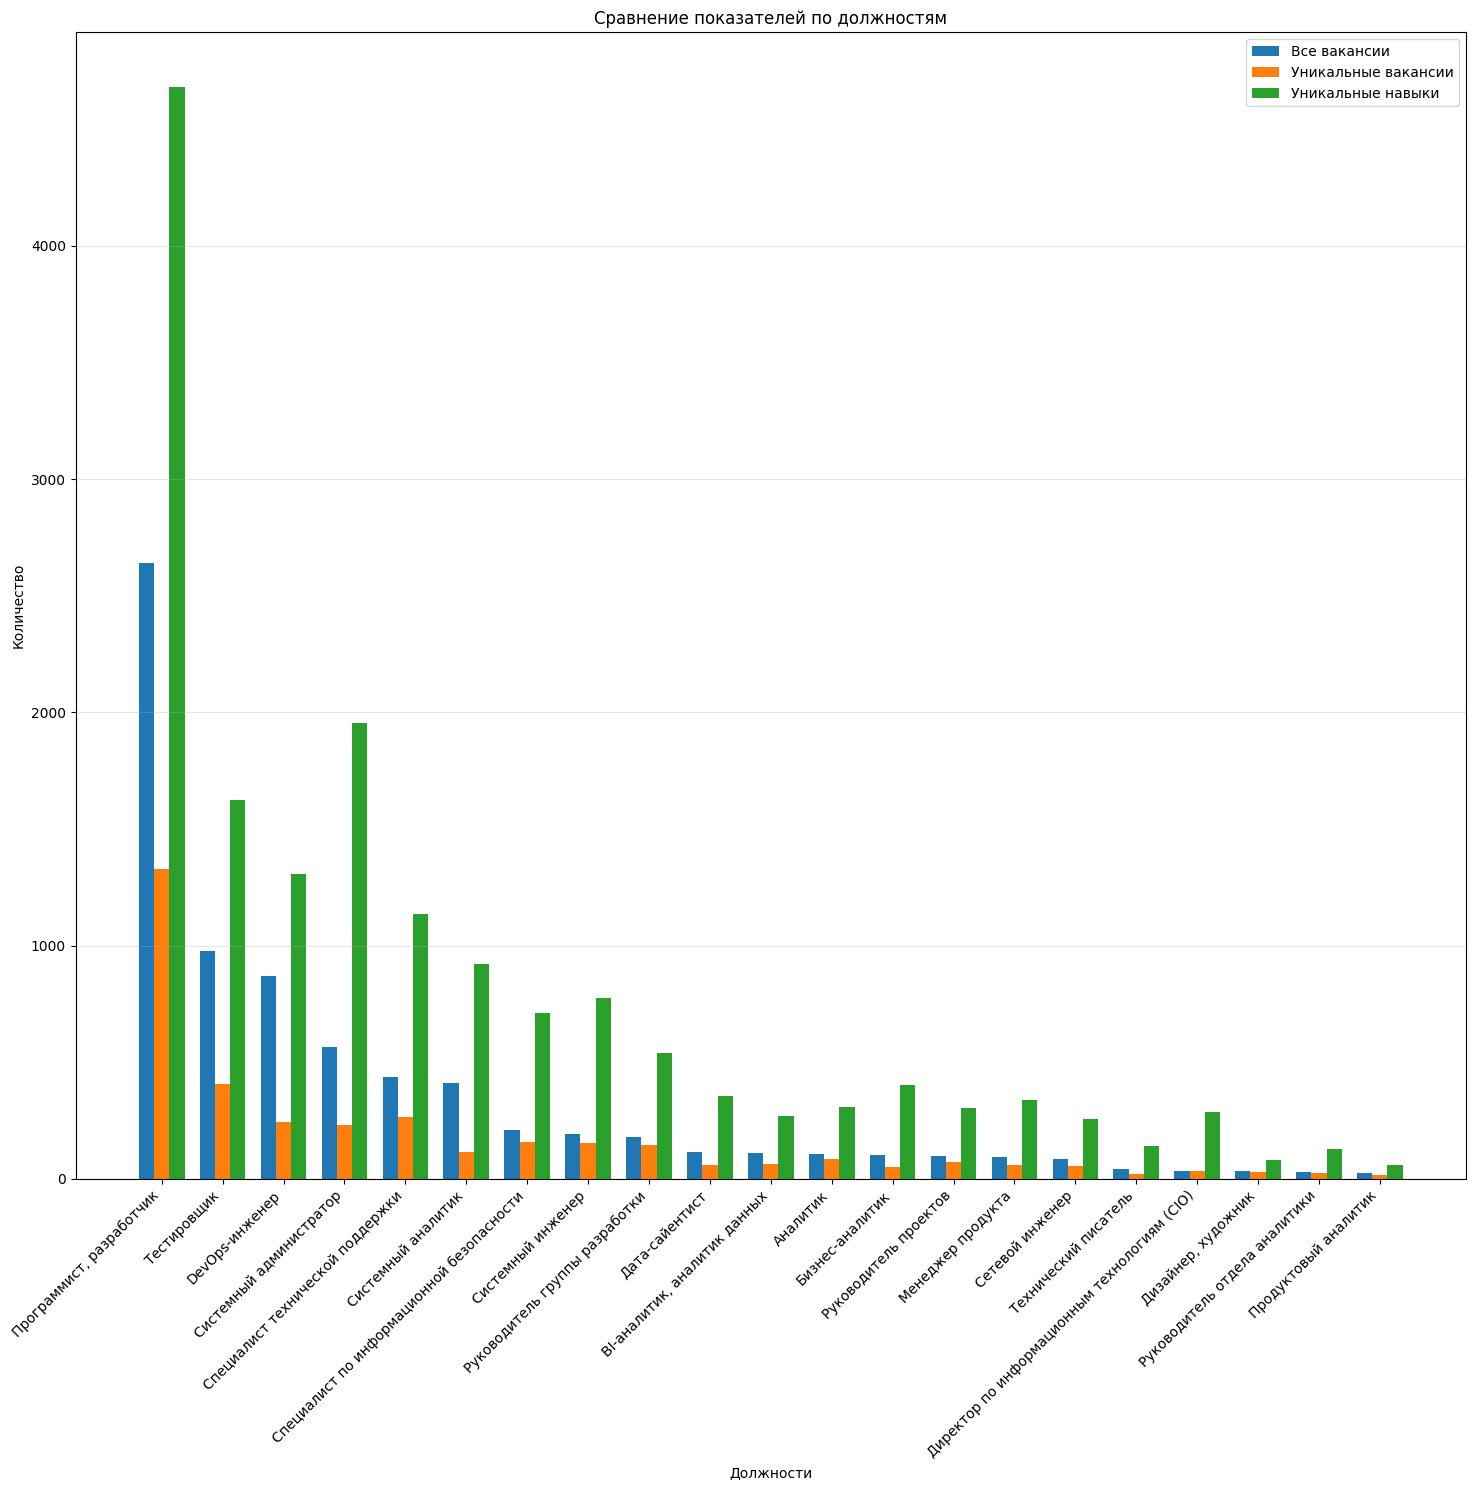

In [295]:
x = range(len(top_positions))
width = 0.25
plt.figure(figsize=(15, 15))
plt.bar(x, top_positions['total_rows'], width, label='Все вакансии')
plt.bar([i + width for i in x], top_positions['vacancy_count'], width, label='Уникальные вакансии')
plt.bar([i + 2*width for i in x], top_positions['unique_skills'], width, label='Уникальные навыки')

plt.title('Сравнение показателей по должностям')
plt.xlabel('Должности')
plt.ylabel('Количество')
plt.xticks([i + width for i in x], top_positions['position'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [296]:
all_skills = flatten_skills(processed_df['skills_processed'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

12938

In [297]:
df['skills_processed'] = processed_df['skills_processed']

In [432]:
#df.to_csv('data/stage_3_df_cluster_vac_to_model_4.csv', index=False)

In [298]:
df['skills_count'] = df['skills_processed'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Считаем распределение
skills_dist = df['skills_count'].value_counts().sort_index().reset_index()
skills_dist.columns = ['Количество навыков', 'Число вакансий']

# Строим интерактивный график
fig = px.bar(
    skills_dist,
    x='Количество навыков',
    y='Число вакансий',
    title='Распределение количества навыков в вакансиях',
    labels={'Количество навыков': 'Число навыков в вакансии', 'Число вакансий': 'Количество вакансий'},
    text='Число вакансий',
    color='Количество навыков',
    color_continuous_scale='Viridis'
)

# Добавляем среднюю линию
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['Число вакансий'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['Число вакансий'].max(),
    text=f"Среднее: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# Настройки отображения
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [434]:
#df['skills_count'] = df['skills_clean_norm'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Считаем распределение
skills_dist = df['skills_count'].value_counts().sort_index().reset_index()
skills_dist.columns = ['Количество навыков', 'Число вакансий']

# Строим интерактивный график
fig = px.bar(
    skills_dist,
    x='Количество навыков',
    y='Число вакансий',
    title='Распределение количества навыков в вакансиях',
    labels={'Количество навыков': 'Число навыков в вакансии', 'Число вакансий': 'Количество вакансий'},
    text='Число вакансий',
    color='Количество навыков',
    color_continuous_scale='Viridis'
)

# Добавляем среднюю линию
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['Число вакансий'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['Число вакансий'].max(),
    text=f"Среднее: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# Настройки отображения
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [299]:
top_positions = df['position'].value_counts().index.tolist()
df_top_positions = df[df['position'].isin(top_positions)]

fig = px.histogram(
    df_top_positions,
    x='skills_count',
    facet_col='position',
    facet_col_wrap=3,
    title='Distribution of Skills Count by Position',
    labels={'skills_count': 'Number of Skills'},
    color='position',
    nbins=15,
    height=2000,  # Увеличил высоту общего графика
    width=1000,
    facet_row_spacing=0.02  # Уменьшил расстояние между строками
)

# Добавление вертикальных линий и аннотаций
for i, position in enumerate(top_positions, 1):
    subplot_df = df_top_positions[df_top_positions['position'] == position]
    median_val = subplot_df['skills_count'].median()
    
    # Добавим вертикальную линию
    fig.add_vline(
        x=median_val,
        line_dash="dot",
        line_color="red",
        opacity=0.7,
        row=(i - 1) // 3 + 1,
        col=(i - 1) % 3 + 1
    )

    # Добавим подпись к среднему значению
    fig.add_annotation(
        x=median_val,
        y=0.85,
        yref='paper',
        text=f'Median: {median_val:.1f}',
        showarrow=False,
        font=dict(color='red'),
        row=(i - 1) // 3 + 1,
        col=(i - 1) % 3 + 1
    )

# Финальные настройки
fig.update_layout(
    showlegend=False,
    hovermode="x",
    xaxis_title='Number of Skills',
    yaxis_title='Number of Vacancies',
    margin=dict(t=80, b=40)
)

fig.update_xaxes(matches=None)
fig.show()

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7368 entries, 0 to 7824
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source             7368 non-null   object 
 1   text               7368 non-null   object 
 2   date               5582 non-null   object 
 3   position           7368 non-null   object 
 4   vacancy            7368 non-null   object 
 5   company            6939 non-null   object 
 6   city               5006 non-null   object 
 7   country            7256 non-null   object 
 8   region             7051 non-null   object 
 9   level              7368 non-null   object 
 10  experience         6106 non-null   object 
 11  employment         7148 non-null   object 
 12  schedule           7230 non-null   object 
 13  skills             7368 non-null   object 
 14  salary from        7368 non-null   float64
 15  salary to          7368 non-null   float64
 16  skills_list        7368 non-n

In [301]:
df.to_csv('data/stage_5_toML.csv', index=False)